# Introduction

Active _cis_-regulatory sequences in the genome are characterized by accessible chromatin and specific histone modifications, which reflect the action of DNA-binding transcription factors (TFs) that recognize specific sequence motifs and recruit chromatin-modifying enzymes [@bib44]. These epigenetic hallmarks of active chromatin are routinely used to train machine learning models that predict _cis_-regulatory sequences, based on the assumption that such epigenetic marks are reliable predictors of genuine _cis_-regulatory sequences [@bib13; @bib19; @bib27; @bib41; @bib50; @bib77; @bib90]. However, results from functional assays show that many predicted _cis_-regulatory sequences exhibit little or no _cis_-regulatory activity. Typically, 50% or more of predicted _cis_-regulatory sequences fail to drive expression in massively parallel reporter assays (MPRAs) [@bib58; @bib48], indicating that an active chromatin state is not sufficient to reliably identify _cis_-regulatory sequences.

Another challenge is that enhancers and silencers are difficult to distinguish by chromatin accessibility or epigenetic state [@bib11; @bib20; @bib62; @bib66; @bib76], and thus computational predictions of _cis-_regulatory sequences often do not differentiate between enhancers and silencers. Silencers are often enhancers in other cell types [@bib5; @bib11; @bib20; @bib30; @bib37; @bib61; @bib62], reside in open chromatin [@bib11; @bib29; @bib30; @bib62], sometimes bear epigenetic marks of active enhancers [@bib14; @bib30], and can be bound by TFs that also act on enhancers in the same cell type [@bib1; @bib21; @bib30; @bib35; @bib37; @bib52; @bib53; @bib65; @bib69; @bib70; @bib80; @bib85]. As a result, enhancers and silencers share similar sequence features, and understanding how they are distinguished in a particular cell type remains an important challenge [@bib76].

The TF cone-rod homeobox (CRX) controls selective gene expression in a number of different photoreceptor and bipolar cell types in the retina [@bib6; @bib17; @bib18; @bib60]. These cell types derive from the same progenitor cell population [@bib45; @bib83], but they exhibit divergent, CRX-directed transcriptional programs [@bib9; @bib25; @bib31; @bib60]. CRX cooperates with cell type-specific co-factors to selectively activate and repress different genes in different cell types and is required for differentiation of rod and cone photoreceptors [@bib7; @bib23; @bib25; @bib28; @bib34; @bib43; @bib51; @bib55; @bib56; @bib60; @bib65; @bib75; @bib79]. However, the sequence features that define CRX-targeted enhancers vs. silencers in the retina are largely unknown.

We previously found that a significant minority of CRX-bound sequences act as silencers in an MPRA conducted in live mouse retinas [@bib85], and that silencer activity requires CRX [@bib86]. Here, we extend our analysis by testing thousands of additional candidate _cis_-regulatory sequences. We show that while regions of accessible chromatin and CRX binding exhibit a range of _cis_-regulatory activity, enhancers and silencers contain more TF motifs than inactive sequences, and that enhancers are distinguished from silencers by a higher diversity of TF motifs. We capture the differences between these sequence classes with a new metric, motif information content (Boltzmann entropy), that considers only the number and diversity of TF motifs in a candidate _cis_-regulatory sequence. Our results suggest that CRX-targeted enhancers are defined by a flexible regulatory grammar and demonstrate how differences in motif information content encode functional differences between genomic loci with similar chromatin states.

In [1]:
# Setup imports for analysis
import os
import sys
import itertools

import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from mpl_toolkits.axes_grid1 import make_axes_locatable
from scipy import stats
from sklearn.feature_selection import RFE, RFECV
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import StratifiedKFold
from pybedtools import BedTool
from IPython.display import display
import logomaker

sys.path.insert(0, "utils")
from utils import fasta_seq_parse_manip, gkmsvm, modeling, plot_utils, predicted_occupancy, quality_control, sequence_annotation_processing

data_dir = os.path.join("Data")
figures_dir = os.path.join("Figures")

# Load in all sequences
all_seqs = fasta_seq_parse_manip.read_fasta(os.path.join(data_dir, "library1And2.fasta"))
# Drop scrambled sequences -- we don't need them for any analysis
all_seqs = all_seqs[~(all_seqs.index.str.contains("scr"))]

In [2]:
plot_utils.set_manuscript_params()

# Results

We tested the activities of 4844 putative CRX-targeted _cis_-regulatory sequences (CRX-targeted sequences) by MPRA in live retinas. The MPRA libraries consist of 164 bp genomic sequences centered on the best match to the CRX position weight matrix (PWM) [@bib49] whenever a CRX motif is present, and matched sequences in which all CRX motifs were abolished by point mutation (Materials and methods). The MPRA libraries include 3299 CRX-bound sequences identified by ChIP-seq in the adult retina [@bib9] and 1545 sequences that do not have measurable CRX binding in the adult retina but reside in accessible chromatin in adult photoreceptors [@bib31] and have the H3K27ac enhancer mark in postnatal day 14 (P14) retina [@bib72] (‘ATAC-seq peaks’). We split the sequences across two plasmid libraries, each of which contained the same 150 scrambled sequences as internal controls ([Supplementary files 1 and 2](#supp1)). We cloned sequences upstream of the rod photoreceptor-specific _Rhodopsin_ (_Rho_) promoter and a _DsRed_ reporter gene, electroporated libraries into explanted mouse retinas at P0 in triplicate, harvested the retinas at P8, and then sequenced the RNA and input DNA plasmid pool. The data is highly reproducible across replicates (R^2^ > 0.96, [Figure 1—figure supplement 1](#fig1s1)). After activity scores were calculated and normalized to the basal _Rho_ promoter, the two libraries were well calibrated and merged together (two-sample Kolmogorov-Smirnov test p = 0.09, [Figure 1—figure supplement 2](#fig1s2), [Supplementary file 3](#supp3), and Materials and methods).

Processing data for library1 with the Rho promoter...
Reading in barcode counts.


label   DNA   RNA1   RNA2   RNA3
barcode                                                                     
AACAACAAG  chr16-87432635-87432799_CPPQ_scrambled  3019    148    325     97
AACAACCGC        chr4-119112319-119112483_CPPE_WT  4117  24493  25950  23406
AACAACGGG        chr7-128854234-128854398_UPCE_WT    86     76     39    233
AACAACTAC        chr4-138107597-138107761_UPPE_WT   827    926    857    659
AACAACTGT          chr5-31298508-31298672_CPPE_WT  7170    492    392    149

Removing detection-limited barcodes and normalizing to counts per million.
Barcodes missing in DNA:
Sample DNA: 1090 barcodes
1090 barcodes are missing from more than 0 DNA samples.
Barcodes off in RNA:
Sample RNA1: 1744 barcodes
Sample RNA2: 1913 barcodes
Sample RNA3: 1491 barcodes
2215 barcodes are off in more than 0 RNA samples.
There are a total of  157.151 million barcode counts.


label         DNA        RNA1  \
barcode                                                                     
AACAACAAG  chr16-87432635-87432799_CPPQ_scrambled   73.436588    4.307406   
AACAACCGC        chr4-119112319-119112483_CPPE_WT  100.145224  712.846538   
AACAACGGG        chr7-128854234-128854398_UPCE_WT    2.091933    2.211911   
AACAACTAC        chr4-138107597-138107761_UPPE_WT   20.116614   26.950390   
AACAACTGT          chr5-31298508-31298672_CPPE_WT  174.408855   14.319214   

                 RNA2        RNA3  
barcode                            
AACAACAAG    7.418047    2.561422  
AACAACCGC  592.302519  618.068596  
AACAACGGG    0.890166    6.152695  
AACAACTAC   19.560819   17.401829  
AACAACTGT    8.947306    3.934556

Normalizing RNA to DNA.
Averaging across barcodes within a replicate.


RNA1      RNA2      RNA3
label                                                                      
BASAL                                          0.331679  0.306512  0.277308
chr1-104768570-104768734_UPCQ_MUT-allCrxSites  1.005172  0.826315  0.930872
chr1-104768570-104768734_UPCQ_WT               1.114088  1.080287  1.091619
chr1-106008207-106008371_CPPE_MUT-allCrxSites  1.180305  1.094909  0.798394
chr1-106008207-106008371_CPPE_WT               0.441799  0.533383  0.868990

Normalizing to the basal Rho promoter.
Computing p-values for the null hypothesis that a sequence is no different than the basal promoter alone.


/home/ryan/Documents/DBBS/CohenLab/Manuscripts/CRX-Information-Content/utils/quality_control.py:408: RuntimeWarning: invalid value encountered in double_scalars
  cov = std / mean


Done processing data!


expression  expression_std  \
label                                                                       
chr1-104768570-104768734_UPCQ_MUT-allCrxSites    3.027744        0.330482   
chr1-104768570-104768734_UPCQ_WT                 3.606621        0.297412   
chr1-106008207-106008371_CPPE_MUT-allCrxSites    3.336604        0.396284   
chr1-106008207-106008371_CPPE_WT                 2.068611        0.944664   
chr1-106171416-106171580_CSPE_scrambled          1.439587        0.579277   

                                               expression_reps  \
label                                                            
chr1-104768570-104768734_UPCQ_MUT-allCrxSites              3.0   
chr1-104768570-104768734_UPCQ_WT                           3.0   
chr1-106008207-106008371_CPPE_MUT-allCrxSites              3.0   
chr1-106008207-106008371_CPPE_WT                           3.0   
chr1-106171416-106171580_CSPE_scrambled                    3.0   

                                               expression_pvalue  \
label                                                              
chr1-104768570-104768734_UPCQ_MUT-allCrxSites           0.000139   
chr1-104768570-104768734_UPCQ_WT                        0.001206   
chr1-106008207-106008371_CPPE_MUT-allCrxSites           0.003039   
chr1-106008207-106008371_CPPE_WT                        0.080583   
chr1-106171416-106171580_CSPE_scrambled                 0.279730   

                                               expression_qvalue  
label                                                             
chr1-104768570-104768734_UPCQ_MUT-allCrxSites           0.000749  
chr1-104768570-104768734_UPCQ_WT                        0.003548  
chr1-106008207-106008371_CPPE_MUT-allCrxSites           0.007388  
chr1-106008207-106008371_CPPE_WT                        0.103242  
chr1-106171416-106171580_CSPE_scrambled                 0.312931

Processing data for library2 with the Rho promoter...
Reading in barcode counts.


label   DNA  RNA1  RNA2  \
barcode                                                                      
AACAACAAG  chr7-141291911-141292075_UPPP_MUT-allCrxSites   132     0     1   
AACAACGTT   chr19-16380352-16380516_CPPN_MUT-allCrxSites  1779    36    17   
AACAACTAC    chr1-44147572-44147736_UPPP_MUT-allCrxSites  2928   433   802   
AACAACTCG              chr12-116230818-116230982_CPPE_WT  2822  3043  2967   
AACAACTGT    chr5-65391346-65391510_CPPP_MUT-allCrxSites  1810  1572  2281   

           RNA3  
barcode          
AACAACAAG     1  
AACAACGTT    46  
AACAACTAC   510  
AACAACTCG  3013  
AACAACTGT  1559

Removing detection-limited barcodes and normalizing to counts per million.
Barcodes missing in DNA:
Sample DNA: 277 barcodes
277 barcodes are missing from more than 0 DNA samples.
Barcodes off in RNA:
Sample RNA1: 875 barcodes
Sample RNA2: 678 barcodes
Sample RNA3: 774 barcodes
1180 barcodes are off in more than 0 RNA samples.
There are a total of  157.724 million barcode counts.


label        DNA  \
barcode                                                               
AACAACAAG  chr7-141291911-141292075_UPPP_MUT-allCrxSites   3.144868   
AACAACGTT   chr19-16380352-16380516_CPPN_MUT-allCrxSites  42.384243   
AACAACTAC    chr1-44147572-44147736_UPPP_MUT-allCrxSites  69.758888   
AACAACTCG              chr12-116230818-116230982_CPPE_WT  67.233464   
AACAACTGT    chr5-65391346-65391510_CPPP_MUT-allCrxSites  43.122810   

                RNA1       RNA2       RNA3  
barcode                                     
AACAACAAG   0.000000   0.000000   0.000000  
AACAACGTT   0.933407   0.406204   1.301935  
AACAACTAC  11.226812  19.163280  14.434499  
AACAACTCG  78.898818  70.894577  85.276757  
AACAACTGT  40.758772  54.503043  44.124283

Normalizing RNA to DNA.
Averaging across barcodes within a replicate.


RNA1      RNA2      RNA3
label                                                                    
BASAL                                        0.196778  0.218638  0.236666
chr1-10229074-10229238_CPPE_MUT-allCrxSites  7.325586  5.922791  6.286389
chr1-10229074-10229238_CPPE_WT               6.418129  5.188716  4.976230
chr1-106171416-106171580_CSPE_MUT-shape      0.282047  0.264416  0.290612
chr1-106171416-106171580_CSPE_WT             0.260469  0.276250  0.212923

Normalizing to the basal Rho promoter.
Computing p-values for the null hypothesis that a sequence is no different than the basal promoter alone.
Done processing data!


expression  expression_std  \
label                                                                     
chr1-10229074-10229238_CPPE_MUT-allCrxSites   30.293101        6.011230   
chr1-10229074-10229238_CPPE_WT                25.791454        6.063103   
chr1-106171416-106171580_CSPE_MUT-shape        1.290214        0.124284   
chr1-106171416-106171580_CSPE_WT               1.162281        0.229405   
chr1-106171416-106171580_CSPE_scrambled        1.995027        0.380942   

                                             expression_reps  \
label                                                          
chr1-10229074-10229238_CPPE_MUT-allCrxSites              3.0   
chr1-10229074-10229238_CPPE_WT                           3.0   
chr1-106171416-106171580_CSPE_MUT-shape                  3.0   
chr1-106171416-106171580_CSPE_WT                         3.0   
chr1-106171416-106171580_CSPE_scrambled                  3.0   

                                             expression_pvalue  \
label                                                            
chr1-10229074-10229238_CPPE_MUT-allCrxSites           0.000003   
chr1-10229074-10229238_CPPE_WT                        0.000019   
chr1-106171416-106171580_CSPE_MUT-shape               0.023905   
chr1-106171416-106171580_CSPE_WT                      0.226254   
chr1-106171416-106171580_CSPE_scrambled               0.012703   

                                             expression_qvalue  
label                                                           
chr1-10229074-10229238_CPPE_MUT-allCrxSites           0.000128  
chr1-10229074-10229238_CPPE_WT                        0.000167  
chr1-106171416-106171580_CSPE_MUT-shape               0.031469  
chr1-106171416-106171580_CSPE_WT                      0.246199  
chr1-106171416-106171580_CSPE_scrambled               0.018175

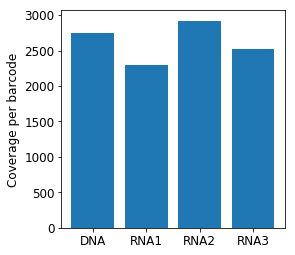

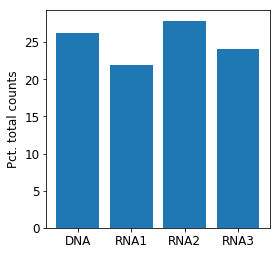

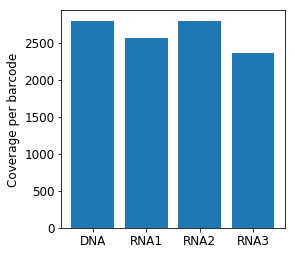

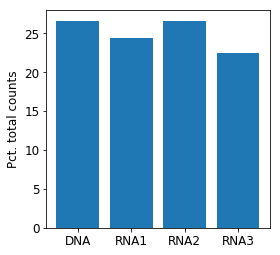

In [3]:
# Process data for the Rho promoter: convert counts into activity scores for each sequence
library_names = ["library1", "library2"]
rho_activity_data = {} # {library name: pd.DataFrame}
barcode_count_dir = os.path.join(data_dir, "Rhodopsin")

for library in library_names:
    print(f"Processing data for {library} with the Rho promoter...")
    # File names
    barcode_count_files = [
        os.path.join(barcode_count_dir, f"{library}{sample}.counts")
        for sample in ["Plasmid", "Rna1", "Rna2", "Rna3"]
    ]
    
    # Masks and metadata for downstream functions
    sample_labels = np.array(["DNA", "RNA1", "RNA2", "RNA3"])
    sample_rna_mask = np.array([False, True, True, True])
    rna_labels = sample_labels[sample_rna_mask]
    dna_labels = sample_labels[np.logical_not(sample_rna_mask)]
    n_samples = len(sample_labels)
    n_rna_samples = len(rna_labels)
    n_dna_samples = len(dna_labels)
    n_barcodes_per_sequence = 3
    
    # Read in the barcode counts
    print("Reading in barcode counts.")
    all_sample_counts_df = quality_control.read_bc_count_files(barcode_count_files, sample_labels)
    display(all_sample_counts_df.head())
    
    # Remove barcodes that are detection-limited.
    # Barcodes below the DNA cutoff are NaN (because they are missing from the input plasmid pool)
    # Barcodes below any of the RNA cutoffs are zero in all replicates
    print("Removing detection-limited barcodes and normalizing to counts per million.")
    cutoffs = [10, 5, 5, 5]
    threshold_sample_counts_df = quality_control.filter_low_counts(all_sample_counts_df, sample_labels, cutoffs,
                                                                   dna_labels=dna_labels, bc_per_seq=n_barcodes_per_sequence)
    display(threshold_sample_counts_df.head())

    # Normalize RNA barcode counts by plasmid barcode counts
    print("Normalizing RNA to DNA.")
    normalized_sample_counts_df = quality_control.normalize_rna_by_dna(threshold_sample_counts_df, rna_labels, dna_labels)
    # Drop DNA
    barcode_sample_counts_df = normalized_sample_counts_df.drop(columns=dna_labels)
    
    # Average across barcodes
    print("Averaging across barcodes within a replicate.")
    activity_replicate_df = quality_control.average_barcodes(barcode_sample_counts_df)
    display(activity_replicate_df.head())
    
    # Basal-normalize, average across replicates, do statistics
    print("Normalizing to the basal Rho promoter.")
    sequence_expression_df = quality_control.basal_normalize(activity_replicate_df, "BASAL")
    print("Computing p-values for the null hypothesis that a sequence is no different than the basal promoter alone.")
    sequence_expression_df["expression_pvalue"] = quality_control.log_ttest_vs_basal(activity_replicate_df, "BASAL")
    sequence_expression_df["expression_qvalue"] = modeling.fdr(sequence_expression_df["expression_pvalue"])
    print(f"Done processing data!")
    display(sequence_expression_df.head())
    
    rho_activity_data[library] = sequence_expression_df

Processing data for library1 with the Polylinker...
Reading in barcode counts.


label   DNA  RNA1  RNA2   RNA3
barcode                                                                   
AACAACAAG  chr16-87432635-87432799_CPPQ_scrambled   987     2     3     10
AACAACCGC        chr4-119112319-119112483_CPPE_WT  1326  4963  4554  17827
AACAACGGG        chr7-128854234-128854398_UPCE_WT    35     0     0      2
AACAACTAC        chr4-138107597-138107761_UPPE_WT     5     8     6      4
AACAACTGT          chr5-31298508-31298672_CPPE_WT  5007   934   993    575

Removing barcodes missing from the DNA pool and normalizing to counts per million.
Removing detection-limited barcodes and normalizing to counts per million.
Barcodes missing in DNA:
Sample DNA: 1722 barcodes
1722 barcodes are missing from more than 0 DNA samples.
Barcodes off in RNA:
Sample RNA1: 0 barcodes
Sample RNA2: 0 barcodes
Sample RNA3: 0 barcodes
0 barcodes are off in more than 0 RNA samples.
There are a total of  92.122 million barcode counts.
Now removing RNA barcodes missing from any replicate.
Barcodes missing in DNA:
Sample DNA: 0 barcodes
0 barcodes are missing from more than 0 DNA samples.
Barcodes off in RNA:
Sample RNA1: 5842 barcodes
Sample RNA2: 11412 barcodes
Sample RNA3: 9805 barcodes
12991 barcodes are off in more than 0 RNA samples.


label         DNA        RNA1  \
barcode                                                                     
AACAACAAG  chr16-87432635-87432799_CPPQ_scrambled   48.214705    0.000000   
AACAACCGC        chr4-119112319-119112483_CPPE_WT   64.774771  238.306557   
AACAACGGG        chr7-128854234-128854398_UPCE_WT         NaN    0.000000   
AACAACTAC        chr4-138107597-138107761_UPPE_WT         NaN    0.000000   
AACAACTGT          chr5-31298508-31298672_CPPE_WT  244.590708   44.847537   

                 RNA2        RNA3  
barcode                            
AACAACAAG    0.000000    0.000000  
AACAACCGC  198.604223  639.087016  
AACAACGGG    0.000000    0.000000  
AACAACTAC    0.000000    0.000000  
AACAACTGT   43.305664   20.613397

Normalizing RNA to DNA.
Averaging across barcodes within a replicate.


RNA1      RNA2      RNA3
label                                                                      
BASAL                                          0.742818  0.983263  1.267636
chr1-104768570-104768734_UPCQ_MUT-allCrxSites  0.000000  0.000000  0.000000
chr1-104768570-104768734_UPCQ_WT               0.000000  0.000000  0.000000
chr1-106008207-106008371_CPPE_MUT-allCrxSites  0.000000  0.000000  0.000000
chr1-106008207-106008371_CPPE_WT               0.000000  0.000000  0.000000

Removing the 'basal' promoter (Polylinker) and averaging across replicates. No statistical analysis is performed here.
Done processing data!


expression  expression_SEM
label                                                                    
chr1-104768570-104768734_UPCQ_MUT-allCrxSites         0.0             0.0
chr1-104768570-104768734_UPCQ_WT                      0.0             0.0
chr1-106008207-106008371_CPPE_MUT-allCrxSites         0.0             0.0
chr1-106008207-106008371_CPPE_WT                      0.0             0.0
chr1-106171416-106171580_CSPE_scrambled               0.0             0.0

Processing data for library2 with the Polylinker...
Reading in barcode counts.


label   DNA  RNA1  RNA2  \
barcode                                                                      
AACAACAAG  chr7-141291911-141292075_UPPP_MUT-allCrxSites     3    20    15   
AACAACGTT   chr19-16380352-16380516_CPPN_MUT-allCrxSites   990    10     9   
AACAACTAC    chr1-44147572-44147736_UPPP_MUT-allCrxSites  1056     2     4   
AACAACTCG              chr12-116230818-116230982_CPPE_WT     7     4     6   
AACAACTGT    chr5-65391346-65391510_CPPP_MUT-allCrxSites  1653  1441     9   

           RNA3  
barcode          
AACAACAAG    21  
AACAACGTT    10  
AACAACTAC     3  
AACAACTCG     0  
AACAACTGT  4695

Removing barcodes missing from the DNA pool and normalizing to counts per million.
Removing detection-limited barcodes and normalizing to counts per million.
Barcodes missing in DNA:
Sample DNA: 2107 barcodes
2107 barcodes are missing from more than 0 DNA samples.
Barcodes off in RNA:
Sample RNA1: 0 barcodes
Sample RNA2: 0 barcodes
Sample RNA3: 0 barcodes
0 barcodes are off in more than 0 RNA samples.
There are a total of  89.662 million barcode counts.
Now removing RNA barcodes missing from any replicate.
Barcodes missing in DNA:
Sample DNA: 0 barcodes
0 barcodes are missing from more than 0 DNA samples.
Barcodes off in RNA:
Sample RNA1: 12647 barcodes
Sample RNA2: 12055 barcodes
Sample RNA3: 10999 barcodes
13873 barcodes are off in more than 0 RNA samples.


label        DNA  RNA1  \
barcode                                                                     
AACAACAAG  chr7-141291911-141292075_UPPP_MUT-allCrxSites        NaN   0.0   
AACAACGTT   chr19-16380352-16380516_CPPN_MUT-allCrxSites  38.377926   0.0   
AACAACTAC    chr1-44147572-44147736_UPPP_MUT-allCrxSites  40.936454   0.0   
AACAACTCG              chr12-116230818-116230982_CPPE_WT        NaN   0.0   
AACAACTGT    chr5-65391346-65391510_CPPP_MUT-allCrxSites  64.079506   0.0   

           RNA2  RNA3  
barcode                
AACAACAAG   0.0   0.0  
AACAACGTT   0.0   0.0  
AACAACTAC   0.0   0.0  
AACAACTCG   0.0   0.0  
AACAACTGT   0.0   0.0

Normalizing RNA to DNA.
Averaging across barcodes within a replicate.


RNA1      RNA2      RNA3
label                                                                    
BASAL                                        0.000000  0.000000  0.000000
chr1-10229074-10229238_CPPE_MUT-allCrxSites  1.486824  0.405204  1.305344
chr1-10229074-10229238_CPPE_WT               0.000000  0.000000  0.000000
chr1-106171416-106171580_CSPE_MUT-shape      0.000000  0.000000  0.000000
chr1-106171416-106171580_CSPE_WT             0.000000  0.000000  0.000000

Removing the 'basal' promoter (Polylinker) and averaging across replicates. No statistical analysis is performed here.
Done processing data!


expression  expression_SEM
label                                                                  
chr1-10229074-10229238_CPPE_MUT-allCrxSites     1.06579        0.334422
chr1-10229074-10229238_CPPE_WT                  0.00000        0.000000
chr1-106171416-106171580_CSPE_MUT-shape         0.00000        0.000000
chr1-106171416-106171580_CSPE_WT                0.00000        0.000000
chr1-106171416-106171580_CSPE_scrambled         0.00000        0.000000

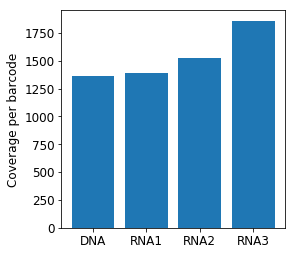

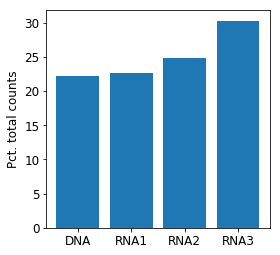

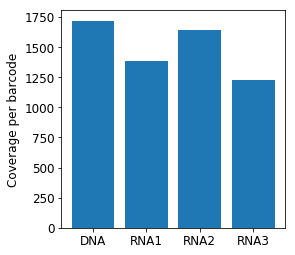

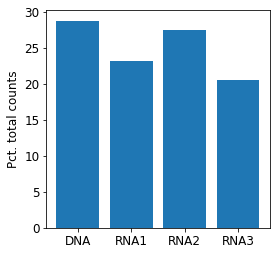

In [4]:
# Now process data for the Polylinker (experiment is in Fig 4, but it is easier to process the data here)
# Process data for the Rho promoter: convert counts into activity scores for each sequence
library_names = ["library1", "library2"]
polylinker_activity_data = {} # {library name: pd.DataFrame}
barcode_count_dir = os.path.join(data_dir, "Polylinker")

for library in library_names:
    print(f"Processing data for {library} with the Polylinker...")
    # File names
    barcode_count_files = [
        os.path.join(barcode_count_dir, f"{library}{sample}.counts")
        for sample in ["Plasmid", "Rna1", "Rna2", "Rna3"]
    ]
    
    # Masks and metadata for downstream functions
    sample_labels = np.array(["DNA", "RNA1", "RNA2", "RNA3"])
    sample_rna_mask = np.array([False, True, True, True])
    rna_labels = sample_labels[sample_rna_mask]
    dna_labels = sample_labels[np.logical_not(sample_rna_mask)]
    n_samples = len(sample_labels)
    n_rna_samples = len(rna_labels)
    n_dna_samples = len(dna_labels)
    n_barcodes_per_sequence = 3
    
    # Read in the barcode counts
    print("Reading in barcode counts.")
    all_sample_counts_df = quality_control.read_bc_count_files(barcode_count_files, sample_labels)
    display(all_sample_counts_df.head())
    
    # Remove barcodes that are detection-limited.
    print("Removing barcodes missing from the DNA pool and normalizing to counts per million.")
    cutoffs_dna_only = [50, 0, 0, 0]
    # Barcodes below the DNA cutoff are NaN (because they are missing from the input plasmid pool)
    # Barcodes below any of the RNA cutoffs are zero in all replicates
    print("Removing detection-limited barcodes and normalizing to counts per million.")
    threshold_sample_counts_df = quality_control.filter_low_counts(all_sample_counts_df, sample_labels, cutoffs_dna_only,
                                                                   dna_labels=dna_labels, bc_per_seq=n_barcodes_per_sequence)
    print("Now removing RNA barcodes missing from any replicate.")
    cutoffs_rna_cpm = [0, 8, 8, 8]
    threshold_sample_counts_df = quality_control.filter_low_counts(threshold_sample_counts_df, sample_labels, cutoffs_rna_cpm,
                                                                  dna_labels=dna_labels, bc_per_seq=n_barcodes_per_sequence, cpm_normalize=False)
    display(threshold_sample_counts_df.head())

    # Normalize RNA barcode counts by plasmid barcode counts
    print("Normalizing RNA to DNA.")
    normalized_sample_counts_df = quality_control.normalize_rna_by_dna(threshold_sample_counts_df, rna_labels, dna_labels)
    # Drop DNA
    barcode_sample_counts_df = normalized_sample_counts_df.drop(columns=dna_labels)
    
    # Average across barcodes
    print("Averaging across barcodes within a replicate.")
    activity_replicate_df = quality_control.average_barcodes(barcode_sample_counts_df)
    display(activity_replicate_df.head())
    
    # Drop "basal" and average across replicates
    print("Removing the 'basal' promoter (Polylinker) and averaging across replicates. No statistical analysis is performed here.")
    activity_replicate_df = activity_replicate_df.drop(index="BASAL")
    sequence_expression_df = activity_replicate_df.apply(lambda x: pd.Series({"expression": x.mean(), "expression_SEM": x.sem()}), axis=1)
    print(f"Done processing data!")
    display(sequence_expression_df.head())
    
    polylinker_activity_data[library] = sequence_expression_df

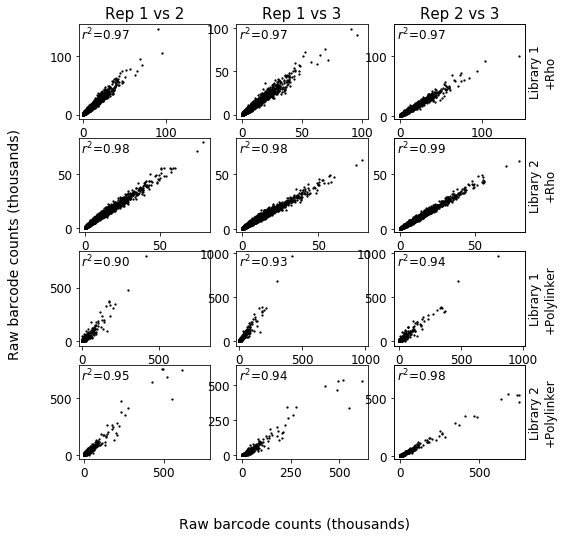

In [5]:
# File names of the raw barcode counts
raw_data_files = [os.path.join(data_dir, dirname, filename) for dirname, filename in itertools.product(["Rhodopsin", "Polylinker"], ["library1RawBarcodeCounts.txt", "library2RawBarcodeCounts.txt"])]
raw_data_names = ["Library 1\n+Rho", "Library 2\n+Rho", "Library 1\n+Polylinker", "Library 2\n+Polylinker"]
comparison_columns = ["Rep 1 vs 2", "Rep 1 vs 3", "Rep 2 vs 3"]
fig, ax_list = plt.subplots(nrows=4, ncols=3, figsize=(8, 8))

# Read in each dataset
for row, filename in enumerate(raw_data_files):
    row_df = pd.read_csv(filename, sep="\t")
    # Get all 3 pairs of combinations and plot them
    for col, (x, y) in enumerate(itertools.combinations(["RNA1", "RNA2", "RNA3"], 2)):
        rsquared = stats.pearsonr(row_df[x], row_df[y])[0] ** 2
        ax = ax_list[row, col]
        ax.scatter(row_df[x] / 1000, row_df[y] / 1000, color="k")
        ax.text(0.02, 0.98, fr"$r^2$={rsquared:.2f}", transform=ax.transAxes, ha="left", va="top")
        max_value = max(ax.get_xlim()[1], ax.get_ylim()[1])
        ax.set_xlim(right=max_value)
        ax.set_ylim(top=max_value)
        
# Add "axis" labels
fig.text(0.5, 0.025, "Raw barcode counts (thousands)", ha="center", va="top", fontsize=14)
fig.text(0.025, 0.5, "Raw barcode counts (thousands)", rotation=90, ha="right", va="center", fontsize=14)

# Add column labels at the top
for col, text in enumerate(comparison_columns):
    ax_list[0, col].set_title(text)
    
# Add row labels on the right
for row, text in enumerate(raw_data_names):
    twinax = ax_list[row, 2].twinx()
    twinax.set_ylabel(text)
    twinax.set_yticks([])
    
display(fig)
plt.close()

Scrambled sequences from L1 and L2 are drawn from the same distribution, KS test p = 0.087, D = 0.14


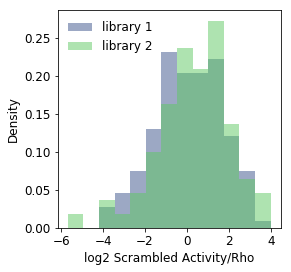

In [6]:
library1_rho_df = rho_activity_data["library1"]
library1_rho_df["library"] = 1
library2_rho_df = rho_activity_data["library2"]
library2_rho_df["library"] = 2

# Get scrambled sequences from each library with RNA barcodes measured
scrambled_library1_df = library1_rho_df[library1_rho_df.index.str.contains("scrambled") & (library1_rho_df["expression"] > 0)]
scrambled_library2_df = library2_rho_df[library2_rho_df.index.str.contains("scrambled") & (library2_rho_df["expression"] > 0)]

# Compare distributions of log2 expression
scrambled_library1_expr = np.log2(scrambled_library1_df["expression"])
scrambled_library2_expr = np.log2(scrambled_library2_df["expression"])
ks_stat, pval = stats.ks_2samp(scrambled_library1_expr, scrambled_library2_expr)
print(f"Scrambled sequences from L1 and L2 are drawn from the same distribution, KS test p = {pval:.3f}, D = {ks_stat:.2f}")

# Show the two histograms
fig, ax = plt.subplots()
ax.hist([scrambled_library2_expr, scrambled_library1_expr], bins="auto", histtype="stepfilled", density=True, label=["library 2", "library 1"], color=plot_utils.set_color([0.75, 0.25]), alpha=0.5)
ax.set_xlabel("log2 Scrambled Activity/Rho")
ax.set_ylabel("Density")
ax.legend(loc="upper left", frameon=False)
display(fig)
plt.close()

In [7]:
# Join and annotate all data
print("Joining together data from the two libraries with the Rho promoter.")
color_mapping = {
    "Strong enhancer": "#1f78b4",
    "Weak enhancer": "#a6cee3",
    "Inactive": "#33a02c",
    "Silencer": "#e31a1c",
    np.nan: "grey"
}

# Join the libraries and add a pseudocount to take log2
rho_df = library1_rho_df.append(library2_rho_df)
rho_pseudocount = 1e-3
rho_df["expression_log2"] = np.log2(rho_df["expression"] + rho_pseudocount)

# Define cutoff for a strong enhancer based on scrambled sequences
print("Annotating sequences as strong enhancer, weak enhancer, inactive, silencer, or ambiguous.")
scrambled_mask = rho_df.index.str.contains("scrambled")
scrambled_df = rho_df[scrambled_mask]
scrambled_df = scrambled_df[scrambled_df["expression"].notna()]
strong_cutoff = scrambled_df["expression_log2"].quantile(0.95)
print(f"Cutoff to call something a strong enhancer: activity is above {strong_cutoff:.2f}")

# Drop scrambled sequences
rho_df = rho_df[~scrambled_mask]

# Helper function to label and color a sequence
def label_color_sequence(row, alpha=0.05, strong_cutoff=strong_cutoff, inactive_cutoff=1, color_mapping=color_mapping):
    expr_log2 = row["expression_log2"]
    qval = row["expression_qvalue"]
    # Inactive
    if (np.abs(expr_log2) <= inactive_cutoff) & (qval >= alpha):
        group = "Inactive"
    # Silencer
    elif (expr_log2 < -inactive_cutoff) & ((qval < alpha) | (row["expression"] == 0)):
        group = "Silencer"
    # Enhancer
    elif (expr_log2 > inactive_cutoff) & (qval < alpha):
        # Strong
        if expr_log2 > strong_cutoff:
            group = "Strong enhancer"
        # Weak
        else:
            group = "Weak enhancer"
    # Ambiguous
    else:
        group = np.nan
    
    color = color_mapping[group]
    return pd.Series({"group_name": group, "plot_color": color})

# Annotate both WT and MUT sequences
rho_df = rho_df.join(rho_df.apply(label_color_sequence, axis=1))
rho_df["group_name"] = sequence_annotation_processing.to_categorical(rho_df["group_name"])

# Now do Polylinker data
library1_poly_df = polylinker_activity_data["library1"]
library2_poly_df = polylinker_activity_data["library2"]
print("Joining together data from the two libraries with the Polylinker promoter and annotate for autonomous activity.")
poly_df = library1_poly_df.append(library2_poly_df)
poly_pseudocount = 1e-2
poly_df["expression_log2"] = np.log2(poly_df["expression"] + poly_pseudocount)
poly_df["autonomous_activity"] = (poly_df["expression_log2"] > 0)

# Compute effect of mutating CRX motifs in the presence of the Rho promoter.
print("Computing the effect size upon mutating CRX motifs in the presence of the Rho promoter.")
print("This is for Figure 5, but it is easier to do it here.")
wt_mask = rho_df.index.str.contains("_WT$")
mut_mask = rho_df.index.str.contains("_MUT-allCrxSites$")

# Add variant info as a column, then trim it off the index
rho_df_no_variant_df = rho_df.copy()
rho_df_no_variant_df["variant"] = rho_df_no_variant_df.index.str.split("_").str[2:].str.join("_")
rho_df_no_variant_df = sequence_annotation_processing.remove_mutations_from_seq_id(rho_df_no_variant_df)

# Separate out WT and MUT, then join them together on the same row
wt_df = rho_df_no_variant_df[wt_mask]
mut_df = rho_df_no_variant_df[mut_mask]
wt_vs_mut_rho_df = wt_df.join(mut_df, lsuffix="_WT", rsuffix="_MUT")
wt_vs_mut_rho_df["wt_vs_mut_log2"] = wt_vs_mut_rho_df["expression_log2_WT"] - wt_vs_mut_rho_df["expression_log2_MUT"]

# Compute parameters for lognormal distribution to do stats
wt_cov = wt_vs_mut_rho_df["expression_std_WT"] / wt_vs_mut_rho_df["expression_WT"]
wt_log_mean = np.log(wt_vs_mut_rho_df["expression_WT"] / np.sqrt(wt_cov**2 + 1))
wt_log_std = np.sqrt(np.log(wt_cov**2 + 1))
mut_cov = wt_vs_mut_rho_df["expression_std_MUT"] / wt_vs_mut_rho_df["expression_MUT"]
mut_log_mean = np.log(wt_vs_mut_rho_df["expression_MUT"] / np.sqrt(mut_cov**2 + 1))
mut_log_std = np.sqrt(np.log(mut_cov**2 + 1))

# Do t-tests and FDR
wt_vs_mut_rho_df["wt_vs_mut_pvalue"] = stats.ttest_ind_from_stats(wt_log_mean, wt_log_std, wt_vs_mut_rho_df["expression_reps_WT"], mut_log_mean, mut_log_std, wt_vs_mut_rho_df["expression_reps_MUT"], equal_var=False)[1]
wt_vs_mut_rho_df["wt_vs_mut_qvalue"] = modeling.fdr(wt_vs_mut_rho_df["wt_vs_mut_pvalue"])

# Pull out WT polylinker measurements
print("Joining Rho and Polylinker data together.")
poly_wt_df = poly_df.copy()
poly_wt_df = poly_wt_df[poly_wt_df.index.str.contains("WT")]

# Drop the variant ID
poly_wt_df = poly_wt_df.rename(index=lambda x: x[:-3], columns={"expression": "expression_POLY", "expression_SEM": "expression_SEM_POLY", "expression_log2": "expression_log2_POLY"})

# Join with Rho
activity_df = wt_vs_mut_rho_df.join(poly_wt_df)

print("Annotating sequences for binding patterns.")
# Get info on CRX binding from the seq ID strings
activity_df["crx_bound"] = activity_df.index.str.contains("_C...$")

# Read in BED files
library_bed = BedTool(os.path.join(data_dir, "library1And2.bed"))
nrl_chip_bed = BedTool(os.path.join("Data", "Downloaded", "ChIP", "nrlPeaksMm10.bed"))
mef2d_chip_bed = BedTool(os.path.join("Data", "Downloaded", "ChIP", "mef2dPeaksMm10.bed"))

# Get binding patterns for NRL and MEF2D
library_nrl_bound_df = library_bed.intersect(nrl_chip_bed, wa=True).to_dataframe()
activity_df["nrl_bound"] = activity_df.index.isin(library_nrl_bound_df["name"])

library_mef2d_bound_df = library_bed.intersect(mef2d_chip_bed, wa=True).to_dataframe()
activity_df["mef2d_bound"] = activity_df.index.isin(library_mef2d_bound_df["name"])

# Helper function to "reverse one hot encode" binding patterns
def annotate_binding(row):
    crx, nrl, mef2d = row[["crx_bound", "nrl_bound", "mef2d_bound"]]
    if crx:
        if nrl:
            if mef2d:
                return "All three"
            else:
                return "CRX+NRL"
        elif mef2d:
            return "CRX+MEF2D"
        else:
            return "CRX only"
    elif nrl:
        if mef2d:
            return "NRL+MEF2D"
        else:
            return "NRL only"
    elif mef2d:
        return "MEF2D only"
    else:
        return "No binding"

activity_df["binding_group"] = activity_df.apply(annotate_binding, axis=1)
print("Done processing and annotating data. This table corresponds to Supplementary file 3.")
display(activity_df.head())

Joining together data from the two libraries with the Rho promoter.
Annotating sequences as strong enhancer, weak enhancer, inactive, silencer, or ambiguous.
Cutoff to call something a strong enhancer: activity is above 2.84
Joining together data from the two libraries with the Polylinker promoter and annotate for autonomous activity.
Computing the effect size upon mutating CRX motifs in the presence of the Rho promoter.
This is for Figure 5, but it is easier to do it here.
Joining Rho and Polylinker data together.
Annotating sequences for binding patterns.


/home/ryan/miniconda/envs/bclab/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in greater
  return (self.a < x) & (x < self.b)
/home/ryan/miniconda/envs/bclab/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in less
  return (self.a < x) & (x < self.b)
/home/ryan/miniconda/envs/bclab/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:1821: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= self.a)


Done processing and annotating data. This table corresponds to Supplementary file 3.


expression_WT  expression_std_WT  \
label                                                             
chr1-104768570-104768734_UPCQ       3.606621           0.297412   
chr1-106008207-106008371_CPPE       2.068611           0.944664   
chr1-106696554-106696718_CPPE       8.261201           1.317719   
chr1-118321635-118321799_CPPP       1.368148           0.397835   
chr1-118589610-118589774_UPCE       0.184993           0.077742   

                               expression_reps_WT  expression_pvalue_WT  \
label                                                                     
chr1-104768570-104768734_UPCQ                 3.0              0.001206   
chr1-106008207-106008371_CPPE                 3.0              0.080583   
chr1-106696554-106696718_CPPE                 3.0              0.000008   
chr1-118321635-118321799_CPPP                 3.0              0.166861   
chr1-118589610-118589774_UPCE                 3.0              0.019478   

                               expression_qvalue_WT  library_WT  \
label                                                             
chr1-104768570-104768734_UPCQ              0.003548           1   
chr1-106008207-106008371_CPPE              0.103242           1   
chr1-106696554-106696718_CPPE              0.000217           1   
chr1-118321635-118321799_CPPP              0.196017           1   
chr1-118589610-118589774_UPCE              0.031968           1   

                               expression_log2_WT    group_name_WT  \
label                                                                
chr1-104768570-104768734_UPCQ            1.851048    Weak enhancer   
chr1-106008207-106008371_CPPE            1.049360              NaN   
chr1-106696554-106696718_CPPE            3.046526  Strong enhancer   
chr1-118321635-118321799_CPPP            0.453279         Inactive   
chr1-118589610-118589774_UPCE           -2.426678         Silencer   

                              plot_color_WT variant_WT      ...       \
label                                                       ...        
chr1-104768570-104768734_UPCQ       #a6cee3         WT      ...        
chr1-106008207-106008371_CPPE          grey         WT      ...        
chr1-106696554-106696718_CPPE       #1f78b4         WT      ...        
chr1-118321635-118321799_CPPP       #33a02c         WT      ...        
chr1-118589610-118589774_UPCE       #e31a1c         WT      ...        

                               wt_vs_mut_pvalue  wt_vs_mut_qvalue  \
label                                                               
chr1-104768570-104768734_UPCQ          0.092328          0.147455   
chr1-106008207-106008371_CPPE          0.145377          0.212937   
chr1-106696554-106696718_CPPE          0.003104          0.013211   
chr1-118321635-118321799_CPPP          0.080966          0.132766   
chr1-118589610-118589774_UPCE          0.005790          0.019789   

                               expression_POLY  expression_SEM_POLY  \
label                                                                 
chr1-104768570-104768734_UPCQ         0.000000             0.000000   
chr1-106008207-106008371_CPPE         0.000000             0.000000   
chr1-106696554-106696718_CPPE         0.795621             0.058574   
chr1-118321635-118321799_CPPP         0.000000             0.000000   
chr1-118589610-118589774_UPCE         0.308888             0.138871   

                               expression_log2_POLY  autonomous_activity  \
label                                                                      
chr1-104768570-104768734_UPCQ             -6.643856                False   
chr1-106008207-106008371_CPPE             -6.643856                False   
chr1-106696554-106696718_CPPE             -0.311827                False   
chr1-118321635-118321799_CPPP             -6.643856                False   
chr1-118589610-118589774_UPCE             -1.648877                False   

                               crx_bound nrl_bound mef

## Strong enhancers and silencers have high CRX motif content

The _cis_-regulatory activities of CRX-targeted sequences vary widely ([Figure 1a](#fig1)). We defined enhancers and silencers as those sequences that have statistically significant activity that is at least twofold above or below the activity of the basal _Rho_ promoter (Welch’s t-test, Benjamini-Hochberg false discovery rate (FDR) q &lt; 0.05, [Supplementary file 3](#supp3)). We defined inactive sequences as those whose activity is both within a twofold change of basal activity and not significantly different from the basal _Rho_ promoter. We further stratified enhancers into strong and weak enhancers based on whether or not they fell above the 95th percentile of scrambled sequences. Using these criteria, 22% of CRX-targeted sequences are strong enhancers, 28% are weak enhancers, 19% are inactive, and 17% are silencers; the remaining 13% were considered ambiguous and removed from further analysis. To test whether these sequences function as CRX-dependent enhancers and silencers in the genome, we examined genes differentially expressed in _Crx^-/-^_ retina [@bib71]. Genes that are de-repressed are more likely to be near silencers (Fisher’s exact test p = 0.001, odds ratio = 2.1, n = 206) and genes that are down-regulated are more likely to be near enhancers (Fisher’s exact test p = 0.02, odds ratio = 1.5, n = 344, Materials and methods), suggesting that our reporter assay identified sequences that act as enhancers and silencers in the genome. We sought to identify features that would accurately classify these different classes of sequences.

In [8]:
# Calculate predicted occupancy of all TFs
print("Computing predicted occupancy of 8 TFs on every WT and mutant sequence. This might take 2-3 minutes.")

# Load in PWMs
pwms = predicted_occupancy.read_pwm_files(os.path.join("Data", "Downloaded", "Pwm", "photoreceptorAndEnrichedMotifs.meme"))
pwms = pwms.rename(lambda x: x.split("_")[0])
# Reverse compliment RAX for display purposes
rax = pwms["RAX"].copy()
rax = rax[::-1].reset_index(drop=True)
rax_rc = rax.copy()
rax_rc["A"] = rax["T"]
rax_rc["C"] = rax["G"]
rax_rc["G"] = rax["C"]
rax_rc["T"] = rax["A"]
pwms["RAX"] = rax_rc
motif_len = pwms.apply(len)
ewms = pwms.apply(predicted_occupancy.ewm_from_letter_prob).apply(predicted_occupancy.ewm_to_dict)
mu = 9

# Do predicted occupancy scans
occupancy_df = predicted_occupancy.all_seq_total_occupancy(all_seqs, ewms, mu, convert_ewm=False)
print("Done computing predicted occupancies. This corresponds to Supplementary table 4.")
display(occupancy_df.head())

# Separate out the WT sequences
wt_occupancy_df = occupancy_df[occupancy_df.index.str.contains("WT$")].copy()
wt_occupancy_df = sequence_annotation_processing.remove_mutations_from_seq_id(wt_occupancy_df)
wt_occupancy_df = wt_occupancy_df.loc[activity_df.index]
n_tfs = len(wt_occupancy_df.columns)

Computing predicted occupancy of 8 TFs on every WT and mutant sequence. This might take 2-3 minutes.
Done computing predicted occupancies. This corresponds to Supplementary table 4.


CRX          GFI1  \
label                                                                 
chr1-4357766-4357930_CPPP_WT                 2.297972  1.871720e-01   
chr1-4357766-4357930_CPPP_MUT-allCrxSites    0.239708  3.783122e-11   
chr1-73826292-73826456_CPPE_WT               2.290427  6.397380e-03   
chr1-73826292-73826456_CPPE_MUT-allCrxSites  0.293410  1.203730e-08   
chr11-87108697-87108861_CPPP_WT              2.718470  6.025624e-01   

                                                      MAZ         MEF2D  \
label                                                                     
chr1-4357766-4357930_CPPP_WT                 2.204502e-08  1.421229e-06   
chr1-4357766-4357930_CPPP_MUT-allCrxSites    2.204502e-08  1.421229e-06   
chr1-73826292-73826456_CPPE_WT               5.577725e-03  1.815852e-09   
chr1-73826292-73826456_CPPE_MUT-allCrxSites  5.577725e-03  6.339047e-11   
chr11-87108697-87108861_CPPP_WT              2.744230e-12  2.986062e-06   

                                                     NDF1       NRL  \
label                                                                 
chr1-4357766-4357930_CPPP_WT                 3.064604e-07  1.001505   
chr1-4357766-4357930_CPPP_MUT-allCrxSites    3.064606e-07  1.411916   
chr1-73826292-73826456_CPPE_WT               6.713635e-07  0.993418   
chr1-73826292-73826456_CPPE_MUT-allCrxSites  6.713632e-07  0.993414   
chr11-87108697-87108861_CPPP_WT              6.477337e-07  0.040965   

                                                     RORB       RAX  
label                                                                
chr1-4357766-4357930_CPPP_WT                 2.370847e-02  0.005755  
chr1-4357766-4357930_CPPP_MUT-allCrxSites    2.340304e-02  0.004416  
chr1-73826292-73826456_CPPE_WT               2.922269e-04  0.000004  
chr1-73826292-73826456_CPPE_MUT-allCrxSites  1.239630e-07  0.000002  
chr11-87108697-87108861_CPPP_WT              4.672926e-05  0.190641

In [9]:
print("Computing information content of sequences.")
entropy_df = occupancy_df.apply(predicted_occupancy.boltzmann_entropy, axis=1)
print("Done computing information content and related metrics. This corresponds to Supplementary table 5.")
display(entropy_df.head())

wt_entropy_df = entropy_df[entropy_df.index.str.contains("WT$")].copy()
wt_entropy_df = sequence_annotation_processing.remove_mutations_from_seq_id(wt_entropy_df)
wt_entropy_df = wt_entropy_df.loc[activity_df.index]

mut_entropy_df = entropy_df[entropy_df.index.str.contains("MUT")].copy()
mut_entropy_df = sequence_annotation_processing.remove_mutations_from_seq_id(mut_entropy_df)
mut_entropy_df = mut_entropy_df.loc[activity_df.index]

Computing information content of sequences.
Done computing information content and related metrics. This corresponds to Supplementary table 5.


total_occupancy  diversity  \
label                                                                     
chr1-4357766-4357930_CPPP_WT                        3.516114        2.0   
chr1-4357766-4357930_CPPP_MUT-allCrxSites           1.679445        1.0   
chr1-73826292-73826456_CPPE_WT                      3.296117        2.0   
chr1-73826292-73826456_CPPE_MUT-allCrxSites         1.292404        1.0   
chr11-87108697-87108861_CPPP_WT                     3.552689        2.0   

                                              entropy  
label                                                  
chr1-4357766-4357930_CPPP_WT                 2.291861  
chr1-4357766-4357930_CPPP_MUT-allCrxSites    0.440493  
chr1-73826292-73826456_CPPE_WT               1.743370  
chr1-73826292-73826456_CPPE_MUT-allCrxSites  0.378922  
chr11-87108697-87108861_CPPP_WT              1.867968

Frequency of each activity bin in WT sequences:


Silencer           0.173615
Inactive           0.192491
Weak enhancer      0.282099
Strong enhancer    0.218005
NaN                0.133790
Name: group_name_WT, dtype: float64

Frequency of activity bins vs. CRX binding status:


group_name_WT  Silencer  Inactive  Weak enhancer  Strong enhancer
crx_bound                                                        
ATAC-seq            281       363            430              211
ChIP-seq            556       565            930              840

ChIP-seq status is independent of if a sequence is inactive, Fisher's exact test p=2e-07, odds ratio=1.49
ChIP-seq status is independent of if a sequence is inactive, Fisher's exact test p=1e-21, odds ratio=2.16


group_name_WT  Silencer  Inactive  Weak enhancer  Strong enhancer
crx_bound                                                        
ATAC-seq       0.218677  0.282490       0.334630         0.164202
ChIP-seq       0.192321  0.195434       0.321688         0.290557

Predicted CRX occupancies:


count      mean       std       min       25%       50%  \
group_name_WT                                                               
Silencer          837.0  2.822068  1.474613  0.013521  1.598510  2.724195   
Inactive          928.0  2.232489  1.342345  0.001052  1.173444  2.048457   
Weak enhancer    1360.0  2.216861  1.220496  0.000385  1.235126  2.113810   
Strong enhancer  1051.0  2.534010  1.169460  0.003694  1.616414  2.490314   

                      75%       max  
group_name_WT                        
Silencer         3.916786  8.028408  
Inactive         3.136282  6.759976  
Weak enhancer    2.988673  7.801177  
Strong enhancer  3.285321  7.368500

Strong enhancers and inactive sequences have the same CRX occupancy, Mann-Whitney U test p = 6e-10 U = 566045.00
Silencers and inactive sequences have the same CRX occupancy, Mann-Whitney U test p = 6e-17, U = 477843.00


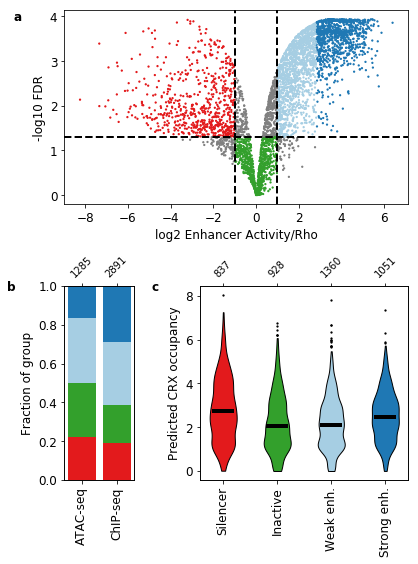

In [10]:
# Mapping activity class to a color
color_mapping = {
    "Silencer": "#e31a1c",
    "Inactive": "#33a02c",
    "Weak enhancer": "#a6cee3",
    "Strong enhancer": "#1f78b4",
    np.nan: "grey"
}
color_mapping = pd.Series(color_mapping)

# Sort order for the four activity bins
class_sort_order = ["Silencer", "Inactive", "Weak enhancer", "Strong enhancer"]
activity_df["group_name_WT"] = sequence_annotation_processing.to_categorical(activity_df["group_name_WT"])
activity_df["group_name_MUT"] = sequence_annotation_processing.to_categorical(activity_df["group_name_MUT"])
rho_ticks = np.arange(-10, 7, 2)

# We can only plot points that were detected in DNA
activity_measured_wt_df = activity_df[activity_df["expression_log2_WT"].notna()]
print("Frequency of each activity bin in WT sequences:")
display(activity_measured_wt_df["group_name_WT"].value_counts(normalize=True, dropna=False, sort=False))

# Count frequency of activity bins for CRX bound/unbound
crx_bound_grouper = activity_df.groupby("crx_bound")
chip_activity_bin_freqs = crx_bound_grouper["group_name_WT"].value_counts().unstack()
chip_activity_bin_freqs = chip_activity_bin_freqs[class_sort_order].rename(index=lambda x: "ChIP-seq" if x else "ATAC-seq")

# Different ways to format group names
chip_group_names_with_n = [f"{i}\nn={j.sum()}" for i, j in chip_activity_bin_freqs.iterrows()]
chip_group_names_with_n_oneline = [" ".join(i.split()) for i in chip_group_names_with_n]
chip_group_names = chip_activity_bin_freqs.index.values
chip_group_count = [j.sum() for i, j in chip_activity_bin_freqs.iterrows()]

# Display the data behind Fig 1b
print("Frequency of activity bins vs. CRX binding status:")
display(chip_activity_bin_freqs)

# Test if CRX binding and inactive status is independent
chip_group_inactive_counts = crx_bound_grouper["group_name_WT"].apply(lambda x: (x == "Inactive").value_counts()).unstack()
oddsratio, pval = stats.fisher_exact(chip_group_inactive_counts)
# Take inverse of odds ratio to match language of manuscript and be more intuitive to the reader
print(f"ChIP-seq status is independent of if a sequence is inactive, Fisher's exact test p={pval:.0e}, odds ratio={1/oddsratio:.2f}")

# Same for strong enhancer
chip_group_inactive_counts = crx_bound_grouper["group_name_WT"].apply(lambda x: (x == "Strong enhancer").value_counts()).unstack()
oddsratio, pval = stats.fisher_exact(chip_group_inactive_counts)
# Take inverse of odds ratio to match language of manuscript and be more intuitive to the reader
print(f"ChIP-seq status is independent of if a sequence is inactive, Fisher's exact test p={pval:.0e}, odds ratio={oddsratio:.2f}")

# Row-normalize the counts
chip_activity_bin_freqs = chip_activity_bin_freqs.div(chip_activity_bin_freqs.sum(axis=1), axis=0)
display(chip_activity_bin_freqs)

# Setup for some downstream stuff
wt_activity_grouper = activity_df.groupby("group_name_WT")
wt_activity_names_oneline = ["Silencer", "Inactive", "Weak enh.", "Strong enh."]
wt_activity_count = [len(j) for i, j in wt_activity_grouper]

# Predicted CRX occupancy vs. WT group
wt_occupancy_grouper = wt_occupancy_df.groupby(activity_df["group_name_WT"])
wt_occupancy_grouper_crx = wt_occupancy_grouper["CRX"]
print("Predicted CRX occupancies:")
display(wt_occupancy_grouper_crx.describe())

# Statistics for differences in CRX occupancy between groups
ustat, pval = stats.mannwhitneyu(wt_occupancy_grouper_crx.get_group("Strong enhancer"), wt_occupancy_grouper_crx.get_group("Inactive"), alternative="two-sided")
print(f"Strong enhancers and inactive sequences have the same CRX occupancy, Mann-Whitney U test p = {pval:.0e} U = {ustat:.2f}")
ustat, pval = stats.mannwhitneyu(wt_occupancy_grouper_crx.get_group("Silencer"), wt_occupancy_grouper_crx.get_group("Inactive"), alternative="two-sided")
print(f"Silencers and inactive sequences have the same CRX occupancy, Mann-Whitney U test p = {pval:.0e}, U = {ustat:.2f}")

# Generate the figure
gs_kw = dict(width_ratios=[1, 3])
fig, ax_list = plt.subplots(nrows=2, ncols=2, figsize=(6, 8), gridspec_kw=gs_kw)
gs = ax_list[0, 0].get_gridspec()
for ax in ax_list[0, :]:
    ax.remove()
    
axbig = fig.add_subplot(gs[0, :])
ax = axbig

# 1a: Volcano plot
fig = plot_utils.volcano_plot(activity_measured_wt_df, "expression_log2_WT", "expression_qvalue_WT",
                             activity_measured_wt_df["plot_color_WT"], xaxis_label="log2 Enhancer Activity/Rho",
                             yaxis_label="-log10 FDR", xline=-np.log10(0.05), yline=[-1, 1],
                             xticks=rho_ticks[1:], figax=(fig, ax))
ax.set_yticks(np.arange(5))
plot_utils.add_letter(ax, -0.125, 1, "a")

# 1b: CRX binding status vs. activity classes
ax = ax_list[1, 0]
fig = plot_utils.stacked_bar_plots(chip_activity_bin_freqs, "Fraction of group", chip_group_names, color_mapping, figax=(fig, ax), vert=True)
ax.set_yticks(np.linspace(0, 1, 6))
plot_utils.rotate_ticks(ax.get_xticklabels())    

# Add ticks above to show the n
ax_twin = ax.twiny()
ax_twin.set_xticks(ax.get_xticks())
ax_twin.set_xlim(ax.get_xlim())
ax_twin.set_xticklabels(chip_group_count, fontsize=10, rotation=45)
plot_utils.add_letter(ax, -0.7, 1.03, "b")

# 1c: Predicted CRX occupancy of different groups
ax = ax_list[1, 1]
fig = plot_utils.violin_plot_groupby(wt_occupancy_grouper_crx, "Predicted CRX occupancy", class_names=wt_activity_names_oneline, class_colors=color_mapping, figax=(fig, ax))
ax.set_yticks(np.linspace(0, 8, 5))
plot_utils.rotate_ticks(ax.get_xticklabels())

# Add ticks above to show the n
ax_twin = ax.twiny()
ax_twin.set_xticks(ax.get_xticks())
ax_twin.set_xlim(ax.get_xlim())
ax_twin.set_xticklabels(wt_activity_count, fontsize=10, rotation=45)
plot_utils.add_letter(ax, -0.2, 1.03, "c")
fig.tight_layout()
display(fig)
plt.close()

Neither CRX ChIP-seq-binding status nor DNA accessibility as measured by ATAC-seq strongly differentiates between these four classes ([Figure 1b](#fig1)). Compared to CRX ChIP-seq peaks, ATAC-seq peaks that lack CRX binding in the adult retina are slightly enriched for inactive sequences (Fisher’s exact test p = 2 × 10^–7^, odds ratio = 1.5) and slightly depleted for strong enhancers (Fisher’s exact test p = 1 × 10^–21^, odds ratio = 2.2). However, sequences with ChIP-seq or ATAC-seq peaks span all four activity categories, consistent with prior reports that DNA accessibility and TF binding data are not sufficient to identify functional enhancers and silencers [@bib11; @bib29; @bib30; @bib62; @bib85].

We examined whether the number and affinity of CRX motifs differentiate enhancers, silencers, and inactive sequences by computing the predicted CRX occupancy (i.e. expected number of bound molecules) for each sequence [@bib85]. Consistent with our previous work [@bib86], both strong enhancers and silencers have higher predicted CRX occupancy than inactive sequences (Mann-Whitney U test, p = 6 × 10^–10^ and 6 × 10^–17^, respectively, [Figure 1c](#fig1)), suggesting that total CRX motif content helps distinguish silencers and strong enhancers from inactive sequences. However, predicted CRX occupancy does not distinguish strong enhancers from silencers: a logistic regression classifier trained with fivefold cross-validation only achieves an area under the receiver operating characteristic (AUROC) curve of 0.548 ± 0.023 and an area under the precision recall (AUPR) curve of 0.571 ± 0.020 ([Figure 2a](#fig2) and [Figure 2—figure supplement 1](#fig2ab)). We thus sought to identify sequence features that distinguish strong enhancers from silencers.

Fitting k-mer Supper Vector Machine. This will take a few minutes.
Fitting strong enhancer vs. silencer logistic regression model for CRX occupancy.
Fitting strong enhancer vs. silencer logistic regression model for 8 TFs.
Optimal regularization strength (C): 1.0e-02


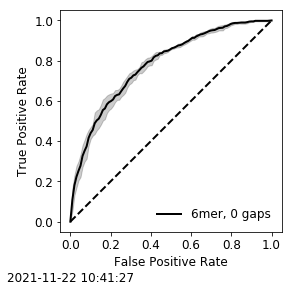

In [11]:
# Prepare data for fitting models
# Mask to pull out the silencers and strong enhancers
silencer_modeling_mask = activity_df["group_name_WT"].str.contains("Strong|Silencer")
silencer_modeling_mask = silencer_modeling_mask & silencer_modeling_mask.notna()
# Mask to pull out the inactive seqs and the strong enhancers
inactive_modeling_mask = activity_df["group_name_WT"].str.contains("Strong|Inactive")
inactive_modeling_mask = inactive_modeling_mask & inactive_modeling_mask.notna()

# Within the data to model, mask indicating which sequences are strong enhancers
labels_with_silencer = activity_df.loc[silencer_modeling_mask, "group_name_WT"].str.contains("Strong")
labels_with_inactive = activity_df.loc[inactive_modeling_mask, "group_name_WT"].str.contains("Strong")

# Write strong enhancers and silencers to file for the SVM
seq_bins_dir = os.path.join(data_dir, "ActivityBins")
positives_fasta = os.path.join(seq_bins_dir, "strongEnhancer.fasta")
negatives_fasta = os.path.join(seq_bins_dir, "silencer.fasta")
all_strong_mask = activity_df["group_name_WT"].str.contains("Strong")
all_strong_mask = all_strong_mask & all_strong_mask.notna()
strong_ids = activity_df.loc[all_strong_mask, "variant_WT"]
fasta_seq_parse_manip.write_fasta(all_seqs[strong_ids.index + "_" + strong_ids], positives_fasta)
all_silencer_mask = activity_df["group_name_WT"].str.contains("Silencer")
all_silencer_mask = all_silencer_mask & all_silencer_mask.notna()
silencer_ids = activity_df.loc[all_silencer_mask, "variant_WT"]
fasta_seq_parse_manip.write_fasta(all_seqs[silencer_ids.index + "_" + silencer_ids], negatives_fasta)

# Fit k-mer SVM
print("Fitting k-mer Supper Vector Machine. This will take a few minutes.")
# Hyperparameter setup
seed = 1210
word_len = 6
max_mis = 1
nfolds = 5

models_dir = "Models"
svm_dir = os.path.join(models_dir, "StrongEnhancerVsSilencer")
if not os.path.exists(svm_dir):
    os.makedirs(svm_dir)

# Fit the SVM
svm_prefix = os.path.join(svm_dir, f"gkmsvm_{word_len}_{word_len}_{max_mis}")
fig_list, xaxis, svm_tpr, svm_prec, svm_f1, svm_scores = gkmsvm.train_with_cv(positives_fasta, negatives_fasta, svm_prefix, num_folds=nfolds, word_len=word_len, info_pos=word_len, max_mis=max_mis, seed=seed)
plt.close()

# Fit logistic regression models
print("Fitting strong enhancer vs. silencer logistic regression model for CRX occupancy.")
cv = StratifiedKFold(n_splits=nfolds, shuffle=True, random_state=seed)
crx_clf = LogisticRegression()
crx_clf, crx_tpr_list, crx_prec_list, crx_f1_list = modeling.train_estimate_variance(crx_clf, cv, wt_occupancy_df.loc[silencer_modeling_mask, "CRX"], labels_with_silencer, xaxis, positive_cutoff=0)

print("Fitting strong enhancer vs. silencer logistic regression model for 8 TFs.")
occ_clf = LogisticRegression()
param_grid = {"C": np.logspace(-4, 4, 9)}
np.random.seed(seed)
occ_clf, occ_tpr_list, occ_prec_list = modeling.grid_search_hyperparams(occ_clf, nfolds, param_grid, "f1", wt_occupancy_df[silencer_modeling_mask], labels_with_silencer, xaxis, positive_cutoff=0)
c_opt = occ_clf.get_params()["C"]
print(f"Optimal regularization strength (C): {c_opt:1.1e}")

figure: Figure 2.
:::
### Strong enhancers contain a diverse array of motifs.
:::
{#fig2}

Model metrics:
SVM	AUROC=0.781+/-0.013	AUPR=0.812+/-0.020
8 TFs	AUROC=0.698+/-0.036	AUPR=0.745+/-0.032
CRX	AUROC=0.548+/-0.023	AUPR=0.571+/-0.020
Total predicted occupancy of all TFs in each group:


count      mean       std       min       25%       50%  \
group_name_WT                                                               
Silencer          837.0  3.588419  1.848387  0.067069  2.167386  3.408131   
Inactive          928.0  3.005903  1.690368  0.034470  1.777625  2.810142   
Weak enhancer    1360.0  3.068334  1.582532  0.010029  1.935493  2.921969   
Strong enhancer  1051.0  3.782727  1.622289  0.021160  2.577761  3.664645   

                      75%        max  
group_name_WT                         
Silencer         4.845272  11.848887  
Inactive         3.968906  12.011682  
Weak enhancer    4.031018  12.521734  
Strong enhancer  4.762179  10.185356

Figure 2, panels A and B:


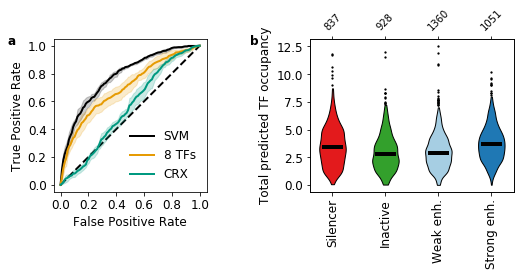

Figure 2--figure supplement 1:


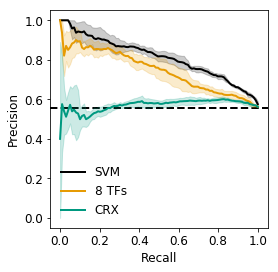

In [12]:
# Generate the figure -- this has to be done in a few pieces
modeling_xaxis = np.linspace(0, 1, 100)
fig, ax_list = plot_utils.setup_multiplot(2, sharex=False, sharey=False)
# Separate figure handle for the PR curves
fig_pr, ax_pr = plt.subplots()

# 2a and supplemental figure 3: ROC and PR curves with SVM, TF occupancies, CRX occupancy
model_data = [ # (TPR, precision, name, color)
    (svm_tpr, svm_prec, "SVM", "black"),
    (occ_tpr_list, occ_prec_list, f"{n_tfs} TFs", "#E69B04"),
    (crx_tpr_list, crx_prec_list, "CRX", "#009980")
]

model_tprs, model_precs, model_names, model_colors = zip(*model_data)
prc_chance = activity_df["group_name_WT"].str.contains("Strong").sum() / activity_df["group_name_WT"].str.contains("Strong|Silencer").sum()

# Generate figures
_, model_aurocs, model_aurocs_std, model_auprs, model_auprs_std = plot_utils.roc_pr_curves(
    modeling_xaxis, model_tprs, model_precs, model_names, model_colors=model_colors,
    prc_chance=prc_chance, figax=([fig, fig_pr], [ax_list[0], ax_pr])
)
ax_list[0].set_xticks(np.linspace(0, 1, 6))
plot_utils.add_letter(ax_list[0], -0.25, 1.03, "a")

# Display model metrics
print("Model metrics:")
for name, auroc, auroc_std, aupr, aupr_std in zip(model_names, model_aurocs, model_aurocs_std, model_auprs, model_auprs_std):
    print(f"{name}\tAUROC={auroc:.3f}+/-{auroc_std:.3f}\tAUPR={aupr:.3f}+/-{aupr_std:.3f}")

# Calculate total predicted occupancy of each class
wt_entropy_grouper = wt_entropy_df.groupby(activity_df["group_name_WT"])
print("Total predicted occupancy of all TFs in each group:")
display(wt_entropy_grouper["total_occupancy"].describe())

# 2b: Total predicted occupancy of each class
ax = ax_list[1]
fig = plot_utils.violin_plot_groupby(wt_entropy_grouper["total_occupancy"], "Total predicted TF occupancy", class_names=wt_activity_names_oneline, class_colors=color_mapping, figax=(fig, ax))
plot_utils.rotate_ticks(ax.get_xticklabels())
plot_utils.add_letter(ax, -0.25, 1.03, "b")

# Add ticks above to show the n
ax_twin = ax.twiny()
ax_twin.set_xticks(ax.get_xticks())
ax_twin.set_xlim(ax.get_xlim())
ax_twin.set_xticklabels(wt_activity_count, fontsize=10, rotation=45)

print("Figure 2, panels A and B:")
fig.tight_layout()
display(fig)
print("Figure 2--figure supplement 1:")
display(fig_pr)
plt.close()
plt.close()

in validate_matrix(): Row sums in df are not close to 1. Reormalizing rows...
Figure 2c


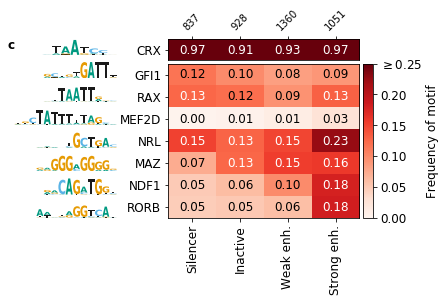

In [13]:
# Calculate motif frequency in each class
occupied_cutoff = 0.5
motif_freq_df = wt_occupancy_grouper.apply(lambda x: (x > occupied_cutoff).sum() / len(x))
# Sort by the feature importance in the logistic model
feature_importance = occ_clf.coef_[0]
feature_order = feature_importance.argsort()
motif_freq_df = motif_freq_df.iloc[:, feature_order]

# Make the fig
fig, ax_list = plt.subplots(nrows=8, ncols=2, figsize=(6, 4), gridspec_kw=dict(width_ratios=[1, 2]))
gs = ax_list[0, 0].get_gridspec()
for ax in ax_list[:, 1]:
    ax.remove()
    
axbig = fig.add_subplot(gs[:, 1])

ax = axbig
vmax = 0.25
thresh = vmax / 2
motif_freq_no_crx_df = motif_freq_df.drop(columns="CRX")
heatmap = ax.imshow(motif_freq_no_crx_df.T, aspect="auto", vmin=0, vmax=vmax, cmap="Reds")
ax.set_xticks(np.arange(len(wt_activity_names_oneline)))
ax.set_xticklabels(wt_activity_names_oneline, rotation=90)
ax.set_yticks(np.arange(len(motif_freq_no_crx_df.columns)))
ax.set_yticklabels(motif_freq_no_crx_df.columns)
plot_utils.annotate_heatmap(ax, motif_freq_no_crx_df, thresh)

# Add the logos
for cax, tf in zip(ax_list[1:, 0], motif_freq_no_crx_df.columns):
    pwm = logomaker.transform_matrix(pwms[tf], from_type="probability", to_type="information")
    logomaker.Logo(pwm, ax=cax, color_scheme="colorblind_safe", show_spines=False)
    # Right-align the logos
    cax.set_xlim(left=motif_len[tf] - motif_len.max() - 0.5)
    cax.set_ylim(top=2)
    cax.set_xticks([])
    cax.set_yticks([])

# Add a colorbar
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad="2%")
colorbar = fig.colorbar(heatmap, cax=cax, label="Frequency of motif")
ticks = cax.get_yticks()
ticks = [f"{i:.2f}" for i in ticks]
ticks[-1] = r"$\geq$" + ticks[-1]
cax.set_yticklabels(ticks)

# Add CRX
cax = divider.append_axes("top", size="14%", pad="2%")
heatmap = cax.imshow(motif_freq_df["CRX"].to_frame().T, aspect="auto", vmin=0, vmax=vmax, cmap="Reds")
cax.xaxis.tick_top()
cax.set_xticks(ax.get_xticks())
cax.set_xlim(ax.get_xlim())
cax.set_xticklabels(wt_activity_count, fontsize=10, rotation=45)
cax.set_yticks([0])
cax.set_yticklabels(["CRX"])
plot_utils.annotate_heatmap(cax, motif_freq_df["CRX"].to_frame(), thresh)

# Add CRX logo
cax = ax_list[0, 0]
pwm = logomaker.transform_matrix(pwms["CRX"], from_type="probability", to_type="information")
logomaker.Logo(pwm, ax=cax, color_scheme="colorblind_safe", show_spines=False)
# Right-align the logos
cax.set_xlim(left=motif_len[tf] - motif_len.max() - 0.5)
cax.set_ylim(top=2)
cax.set_xticks([])
cax.set_yticks([])

plot_utils.add_letter(cax, 0, 1.03, "c")
print("Figure 2c")
fig.tight_layout(pad=0)
display(fig)
plt.close()

group_name_WT  Silencer  Inactive  Weak enhancer  Strong enhancer
binding_group                                                    
No binding     0.221493  0.286300       0.331419         0.160788
CRX only       0.203553  0.222276       0.346615         0.227556
CRX+NRL        0.192560  0.115974       0.238512         0.452954
CRX+MEF2D      0.145000  0.165000       0.280000         0.410000
All three      0.099338  0.105960       0.284768         0.509934

Figure 2, panels D-F


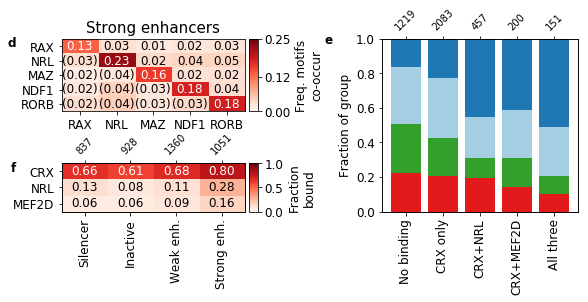

In [14]:
# Setup figure
fig, ax_list = plt.subplots(nrows=2, ncols=2, figsize=(8, 4), gridspec_kw=dict(height_ratios=[3, 2]))
ax2d = ax_list[0, 0]
ax2f = ax_list[1, 0]
for ax in ax_list[:, 1]:
    ax.remove()

ax2e = fig.add_subplot(ax2d.get_gridspec()[:, 1])

# Calculate co-occurrance of motifs in strong enhancers
strong_enh_coocc_df = wt_occupancy_grouper.get_group("Strong enhancer")[["RAX", "NRL", "MAZ", "NDF1", "RORB"]]
strong_enh_coocc_df = (strong_enh_coocc_df > occupied_cutoff).astype(int)
strong_enh_coocc_df = strong_enh_coocc_df.T.dot(strong_enh_coocc_df) / len(strong_enh_coocc_df)
# Fill in lower triangle with the expected values
for row in range(len(strong_enh_coocc_df)):
    for col in range(row + 1, len(strong_enh_coocc_df)):
        strong_enh_coocc_df.iloc[row, col] = strong_enh_coocc_df.iloc[row, row] * strong_enh_coocc_df.iloc[col, col]
        
# 2d: Make the heatmap
ax = ax2d
vmax = 0.25
thresh = vmax / 2
heatmap = ax.imshow(strong_enh_coocc_df, aspect="auto", cmap="Reds", vmax=vmax, vmin=0)
ax.set_title("Strong enhancers")
ax.set_xticks(np.arange(len(strong_enh_coocc_df.columns)))
ax.set_xticklabels(strong_enh_coocc_df.columns)
ax.set_yticks(np.arange(len(strong_enh_coocc_df.columns)))
ax.set_yticklabels(strong_enh_coocc_df.columns)
plot_utils.annotate_heatmap(ax, strong_enh_coocc_df, thresh, adjust_lower_triangle=True)

# Add colorbar
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad="2%")
colorbar = fig.colorbar(heatmap, cax=cax, label="Freq. motifs\nco-occur", ticks=[0, round(thresh, 2), vmax])
plot_utils.add_letter(ax, -0.25, 1.03, "d")

# Calculate activity classes for different binding combos
binding_combos_activity_freq = activity_measured_wt_df.groupby("binding_group")["group_name_WT"].value_counts().unstack()
binding_combos_activity_freq = binding_combos_activity_freq[class_sort_order]
# Ignore cases where there is NRL or MEF2D but not CRX
binding_combos_activity_freq = binding_combos_activity_freq.loc[["No binding", "CRX only", "CRX+NRL", "CRX+MEF2D", "All three"]]
binding_combos_activity_freq = binding_combos_activity_freq.astype(int)

# Generate names then normalize data
binding_combos_names = binding_combos_activity_freq.index.values
binding_combos_count = [j.sum() for i, j in binding_combos_activity_freq.iterrows()]
binding_combos_activity_freq = binding_combos_activity_freq.div(binding_combos_activity_freq.sum(axis=1), axis=0)
display(binding_combos_activity_freq)

# 2e: make plot
ax = ax2e
fig = plot_utils.stacked_bar_plots(binding_combos_activity_freq, "Fraction of group", binding_combos_names, color_mapping, figax=(fig, ax), vert=True)
ax.set_yticks(np.linspace(0, 1, 6))
plot_utils.rotate_ticks(ax.get_xticklabels())

# Add the n
ax_twin = ax.twiny()
ax_twin.set_xticks(ax.get_xticks())
ax_twin.set_xlim(ax.get_xlim())
ax_twin.set_xticklabels(binding_combos_count, fontsize=10, rotation=45)
plot_utils.add_letter(ax, -0.25, 1.03, "e")

# Frequency each class is bound by each TF
group_bound_freqs = activity_measured_wt_df.groupby("group_name_WT")[["crx_bound", "nrl_bound", "mef2d_bound"]].apply(lambda x: x.sum() / len(x))
group_bound_freqs.columns = group_bound_freqs.columns.str.split("_").str[0].str.upper()

# 2f: Make heatmakt
vmax = 1
thresh = vmax / 2
ax = ax2f
heatmap = ax.imshow(group_bound_freqs.T, aspect="auto", cmap="Reds", vmax=vmax, vmin=0)
ax.set_xticks(np.arange(len(wt_activity_names_oneline)))
ax.set_xticklabels(wt_activity_names_oneline, rotation=90)
ax.set_yticks(np.arange(len(group_bound_freqs.columns)))
ax.set_yticklabels(group_bound_freqs.columns)
plot_utils.annotate_heatmap(ax, group_bound_freqs, thresh)

# Add colorbar
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad="2%")
colorbar = fig.colorbar(heatmap, cax=cax, label="Fraction\nbound")
plot_utils.add_letter(ax, -0.25, 1.03, "f")

# Add ticks above to show the n
ax_twin = ax.twiny()
ax_twin.set_axes_locator(ax.get_axes_locator())
ax_twin.set_xticks(ax.get_xticks())
ax_twin.set_xlim(ax.get_xlim())
ax_twin.set_xticklabels(wt_activity_count, fontsize=10, rotation=45)

print("Figure 2, panels D-F")
fig.tight_layout(pad=0)
display(fig)
plt.close()

## Lineage-defining TF motifs differentiate strong enhancers from silencers

We performed a de novo motif enrichment analysis to identify motifs that distinguish strong enhancers from silencers and found several differentially enriched motifs matching known TFs. For motifs that matched multiple TFs, we selected one representative TF for downstream analysis, since TFs from the same family have PWMs that are too similar to meaningfully distinguish between motifs for these TFs ([Figure 2—figure supplement 2](#fig2s2), Materials and methods). Strong enhancers are enriched for several motif families that include TFs that interact with CRX or are important for photoreceptor development: NeuroD1/NDF1 (E-box-binding bHLH) [@bib59], RORB (nuclear receptor) [@bib36; @bib79], MAZ or Sp4 (C2H2 zinc finger) [@bib51], and NRL (bZIP) [@bib55; @bib56]. Sp4 physically interacts with CRX in the retina [@bib51], but we chose to represent the zinc finger motif with MAZ because it has a higher quality score in the HOCOMOCO database [@bib46]. Silencers were enriched for a motif that resembles a partial K50 homeodomain motif but instead matches the zinc finger TF GFI1, a member of the Snail repressor family [@bib8] expressed in developing retinal ganglion cells [@bib88]. Therefore, while strong enhancers and silencers are not distinguished by their CRX motif content, strong enhancers are uniquely enriched for several lineage-defining TFs.

To quantify how well these TF motifs differentiate strong enhancers from silencers, we trained two different classification models with fivefold cross-validation. First, we trained a 6-mer support vector machine (SVM) [@bib19] and achieved an AUROC of 0.781 ± 0.013 and AUPR of 0.812 ± 0.020 ([Figure 2a](#fig2) and [Figure 2—figure supplement 1](#fig2ab)). The SVM considers all 2080 non-redundant 6-mers and provides an upper bound to the predictive power of models that do not consider the exact arrangement or spacing of sequence features. We next trained a logistic regression model on the predicted occupancy for eight lineage-defining TFs ([Supplementary file 4](#supp4)) and compared it to the upper bound established by the SVM. In this model, we considered CRX, the five TFs identified in our motif enrichment analysis, and two additional TFs enriched in photoreceptor ATAC-seq peaks [@bib31]: RAX, a Q50 homeodomain TF that contrasts with CRX, a K50 homeodomain TF [@bib34] and MEF2D, a MADS box TF which co-binds with CRX [@bib2]. The logistic regression model performs nearly as well as the SVM (AUROC 0.698 ± 0.036, AUPR 0.745 ± 0.032, [Figure 2a](#fig2) and [Figure 2—figure supplement 1](#fig2ab)) despite a 260-fold reduction from 2080 to 8 features. To determine whether the logistic regression model depends specifically on the eight lineage-defining TFs, we established a null distribution by fitting 100 logistic regression models with randomly selected TFs (Materials and methods). Our logistic regression model outperforms the null distribution (one-tailed Z-test for AUROC and AUPR, p &lt; 0.0008, [Figure 2—figure supplement 3](#fig2s3)), indicating that the performance of the model specifically requires the eight lineage-defining TFs. To determine whether the SVM identified any additional motifs that could be added to the logistic regression model, we generated de novo motifs using the SVM _k_-mer scores and found no additional motifs predictive of strong enhancers. Finally, we found that our two models perform similarly on an independent test set of CRX-targeted sequences ([@bib85]; [Figure 2—figure supplement 3](#fig2s3)). Since the logistic regression model performs near the upper bound established by the SVM and depends specifically on the eight selected motifs, we conclude that these motifs comprise nearly all of the sequence features captured by the SVM that distinguish strong enhancers from silencers among CRX-targeted sequences.

figure: Figure 2—figure supplement 2.
:::
![](elife-67403.xml.media/fig2-figsupp2.jpg)

### Results from de novo motif analysis.

Motifs enriched in strong enhancers (**a**) and silencers (**b**). Bottom, de novo motif identified with DREME; top, matched known motif identified with TOMTOM.
:::
{#fig2s2}

figure: Figure 2—figure supplement 3.
:::
### Additional validation of the eight transcription factors (TFs) predicted occupancy logistic regression model.
:::
{#fig2s3}

Only panels A and B are shown here. Generating the data for panels C and D will take approximately 50 minutes. If you are interested in generating these panels, the code is in the next cell, but commented out.
Computing predicted occupancy of all TFs on the test set.
Done computing predicted occupancy.


CRX          GFI1           MAZ         MEF2D  \
label                                                                       
chr1_100559800_SCRUBR  0.274096  2.545296e-13  1.630613e-11  4.707551e-14   
chr1_100559800_UBR     1.178397  5.862032e-11  1.102815e-06  1.221394e-10   
chr1_100750470_UBR     2.430898  8.232504e-07  5.564299e-11  2.960941e-10   
chr1_108920170_UBR     2.072197  7.323860e-03  6.147587e-16  4.758899e-09   
chr1_11177090_SCRUBR   3.214338  4.034044e-04  4.444271e-14  2.389581e-07   

                               NDF1       NRL          RORB       RAX  
label                                                                  
chr1_100559800_SCRUBR  1.017487e-07  0.000854  4.694361e-05  0.008889  
chr1_100559800_UBR     1.066875e-03  0.000541  8.777171e-07  0.001608  
chr1_100750470_UBR     1.272582e-02  0.969272  1.295348e-06  0.001267  
chr1_108920170_UBR     2.658399e-10  0.808744  5.559077e-03  0.003341  
chr1_11177090_SCRUBR   3.627830e-10  0.000005  1.550753e-03  2.118118

Making predictions on the test set with the SVM and 8 TF logistic regression model.
Model performance on White 2013 test set:
SVM	AUROC = 0.800	AUPR = 0.821
8 TFs	AUROC = 0.662	AUPR = 0.714


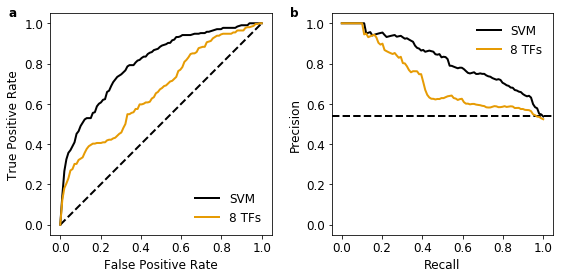

In [15]:
print("Only panels A and B are shown here. Generating the data for panels C and D will take approximately 50 minutes. If you are interested in generating these panels, the code is in the next cell, but commented out.")
white_data_dir = os.path.join("Data", "Downloaded", "CrxMpraLibraries")
white_seqs = pd.read_csv(os.path.join(white_data_dir, "white2013Sequences.txt"), sep="\t", header=None, usecols=[0, 8], index_col=0, squeeze=True, names=["label", "sequence"])
# Only keep barcode1 sequences since barcode info isn't needed
bc_tag = "_barcode1"
white_seqs = white_seqs[white_seqs.index.str.contains(bc_tag)]
# Trim off the barcode ID
white_seqs = white_seqs.rename(lambda x: x[1:-len(bc_tag)])
# Only keep the 84 bp of the sequence that corresponds to the library
seq_len = 84
seq_start = len("TAGCGTCTGTCCGTGAATTC") + 1
white_seqs = white_seqs.str[seq_start:seq_start+seq_len]
# Function to correct off by one error in labeling
def correct_label(name):
    chrom, pos, group = name.split("_")
    pos = int(pos) + 1
    return "_".join([chrom, str(pos), group])

white_activity_df = pd.read_csv(os.path.join(white_data_dir, "white2013Activity.txt"), sep="\t", index_col=0, usecols=[0, 1, 2, 3], names=["label", "class", "expression", "expression_SEM"], header=0)
# Correct the off by one error of the labels
white_activity_df = white_activity_df.rename(correct_label)
white_activity_df["expression_log2"] = np.log2(white_activity_df["expression"])

white_measured_seqs = white_seqs[white_activity_df.index]

print("Computing predicted occupancy of all TFs on the test set.")
white_occupancy_df = predicted_occupancy.all_seq_total_occupancy(white_measured_seqs, ewms, mu, convert_ewm=False)
print("Done computing predicted occupancy.")
display(white_occupancy_df.head())

# Define cutoffs
scrambled_mask = white_activity_df["class"].str.contains("SCR")
strong_cutoff = white_activity_df.loc[scrambled_mask, "expression_log2"].quantile(0.95)
white_scrambled_mean = white_activity_df.loc[scrambled_mask, "expression_log2"].mean()

# Pull out bound sequences
bound_mask = white_activity_df["class"].str.match("CBR(M|NO)$")
bound_activity_df = white_activity_df[bound_mask].copy()
bound_occupancy_df = white_occupancy_df[bound_mask]

# Pull out relevant sequences
white_strong_mask = bound_activity_df["expression_log2"] > strong_cutoff
white_silencer_mask = bound_activity_df["expression_log2"] < (white_scrambled_mean - 1)
white_modeling_mask = white_strong_mask | white_silencer_mask
white_labels = white_strong_mask[white_modeling_mask]

# Make predictions
print("Making predictions on the test set with the SVM and 8 TF logistic regression model.")
# Write sequences to file for the SVM
white_modeling_seqs = white_seqs[bound_activity_df.index][white_modeling_mask]
white_modeling_fasta = os.path.join(svm_dir, "white2013TestSet.fasta")
fasta_seq_parse_manip.write_fasta(white_modeling_seqs, white_modeling_fasta)

# SVM
svm_white_tpr, svm_white_prec, svm_white_scores, svm_white_f1 = gkmsvm.predict_and_eval(white_modeling_fasta, white_labels, svm_prefix, word_len, word_len, max_mis, xaxis)

# Logistic model
occupancy_probs = occ_clf.predict_proba(bound_occupancy_df[white_modeling_mask])
occupancy_white_tpr, occupancy_white_prec, occupancy_white_f1 = modeling.calc_tpr_precision_fbeta(white_labels, occupancy_probs[:, 1], xaxis, positive_cutoff=0.5)

# Setup figure
fig, ax_list = plot_utils.setup_multiplot(2, n_cols=2, sharex=False, sharey=False)

# Plot White 2013 test set
_, white_aurocs, _, white_auprs, _ = plot_utils.roc_pr_curves(
    modeling_xaxis, [svm_white_tpr, occupancy_white_tpr], [svm_white_prec, occupancy_white_prec],
    model_names[:2], model_colors=model_colors[:2], prc_chance=svm_white_prec[-1],
    figax=([fig, fig], ax_list)
)

plot_utils.add_letter(ax_list[0], -0.15, 1.03, "a")
plot_utils.add_letter(ax_list[1], -0.15, 1.03, "b")

# Display model performance
print("Model performance on White 2013 test set:")
print(f"{model_names[0]}\tAUROC = {white_aurocs[0]:.3f}\tAUPR = {white_auprs[0]:.3f}")
print(f"{model_names[1]}\tAUROC = {white_aurocs[1]:.3f}\tAUPR = {white_auprs[1]:.3f}")
fig.tight_layout()
display(fig)
plt.close()

figure: Figure 2—figure supplement 3c and d, static.
:::
![](elife-67403.xml.media/fig2-figsupp3.jpg)

Static version of the figure to display panels (**c**) and (**d**). Null distribution of 100 logistic regression models trained using randomly selected motifs (gray) compared to the true features (orange). Shaded area, 1 standard deviation based on fivefold cross-validation. (**c**) Receiver operating characteristic, (**d**) precision recall curve. Dashed black line represents chance in both panels.
:::
{#fig2s3cd_static}

In [16]:
# # Read in HOCOMOCO database
# hocomoco = predicted_occupancy.read_pwm_files(os.path.join("Data", "Downloaded", "Pwm", "photoreceptorMotifsAndHOCOMOCOv11_full_MOUSE.meme"))
# hocomoco = hocomoco.apply(predicted_occupancy.ewm_from_letter_prob).apply(predicted_occupancy.ewm_to_dict)

# wt_seqs = all_seqs[all_seqs.index.str.contains("WT")].copy()
# wt_seqs = sequence_annotation_processing.remove_mutations_from_seq_id(wt_seqs)
# wt_seqs = wt_seqs[activity_df.index]
# modeling_seqs = wt_seqs[silencer_modeling_mask]

# niter = 100
# nfeatures = len(ewms)
# # Track the cross-validated mean TPR and precision for each feature set
# random_tprs = []
# random_precs = []
# # Keep track of the features selected for each round
# random_ewms = []

# np.random.seed(seed)
# for i in range(niter):
#     if i % 10 == 9:
#         print(f"Iteration {i+1}")
        
#     # Randomly sample PWMs
#     sample = hocomoco.sample(nfeatures)
#     random_ewms.append(sample.index.str.split("_").str[0].values)
#     # Do predicted occupancy scan
#     features = predicted_occupancy.all_seq_total_occupancy(modeling_seqs, sample, mu, convert_ewm=False)
#     # Fit the model
#     clf = LogisticRegression(C=c_opt)
#     clf, tpr, prec, f1 = modeling.train_estimate_variance(clf, cv, features, labels_with_silencer, xaxis, positive_cutoff=0)
    
#     # Store the result
#     random_tprs.append(np.mean(tpr, axis=0))
#     random_precs.append(np.mean(prec, axis=0))
    
# fig, ax_list = plot_utils.setup_multiplot(2, n_cols=2, sharex=False, sharey=False)
# niter_rand = len(random_occ_tprs)
# rand_tpr_plotting = [[j] for i, j in random_occ_tprs.iterrows()] + [occ_tpr_cv]
# rand_prec_plotting = [[j] for i, j in random_occ_precs.iterrows()] + [occ_prec_cv]
# rand_names = [""]  * niter_rand + ["True features"]
# rand_colors = ["#8080801A"] * niter_rand + ["#E69B04"]

# _, background_aurocs, _, background_auprs, _ = plot_utils.roc_pr_curves(
#     modeling_xaxis, rand_tpr_plotting, rand_prec_plotting, rand_names, model_colors=rand_colors,
#     prc_chance=prc_chance, figax=([fig, fig], ax_list)
# )

# plot_utils.add_letter(ax_list[0], -0.15, 1.03, "c")
# plot_utils.add_letter(ax_list[1], -0.15, 1.03, "d")

# # KS test, null hypothesis: random AUROCs and AUPRs are normally distributed
# # One-tailed Z-test that the real data is drawn from this distribution
# for data, name in zip([background_aurocs, background_auprs], ["AUROC", "AUPR"]):
#     real, rand = data[niter_rand], data[:niter_rand]
#     dstat, pval = stats.kstest(stats.zscore(rand), "norm")
#     print(f"{name}s of random features are normally distributed, KS test p = {pval:.2f}, D = {dstat:.2f}")
#     zscore = (real - np.mean(rand)) / np.std(rand)
#     pval = stats.norm.cdf(-np.abs(zscore))
#     print(f"Probability that the {name} of the real features is drawn from the background distribution, one-tailed Z-test p = {pval:2f}")

# display(fig)
# plt.close()

## Strong enhancers are characterized by diverse total motif content

To understand how these eight TF motifs differentiate strong enhancers from silencers, we first calculated the total predicted occupancy of each sequence by all eight lineage-defining TFs and compared the different activity classes. Strong enhancers and silencers both have higher total predicted occupancies than inactive sequences, but total predicted occupancies do not distinguish strong enhancers and silencers from each other ([Figure 2b](#fig2), [Supplementary file 5](#supp5)). Since strong enhancers are enriched for several motifs relative to silencers, this suggests that strong enhancers are distinguished from silencers by the diversity of their motifs, rather than the total number.

We considered two hypotheses for how the more diverse collection of motifs function in strong enhancers: either strong enhancers depend on specific combinations of TF motifs (‘TF identity hypothesis’) or they instead must be co-occupied by multiple lineage-defining TFs, regardless of TF identity (‘TF diversity hypothesis’). To distinguish between these hypotheses, we examined which specific motifs contribute to the total motif content of strong enhancers and silencers. We considered motifs for a TF present in a sequence if the TF predicted occupancy was above 0.5 molecules ([Supplementary file 4](#supp4)), which generally corresponds to at least one motif with a relative _K_~D~ above 3%. This threshold captures the effect of low affinity motifs that are often biologically relevant [@bib10; @bib15; @bib16; @bib63]. As expected, 97% of strong enhancers and silencers contain CRX motifs since the sequences were selected based on CRX binding or significant matches to the CRX PWM within open chromatin ([Figure 2c](#fig2)). Compared to silencers, strong enhancers contain a broader diversity of motifs for the eight lineage-defining TFs ([Figure 2c](#fig2)). However, while strong enhancers contain a broader range of motifs, no single motif occurs in a majority of strong enhancers: NRL motifs are present in 23% of strong enhancers, NeuroD1 and RORB in 18% each, and MAZ in 16%. Additionally, none of the motifs tend to co-occur as pairs in strong enhancers: no specific pair occurred in more than 5% of sequences ([Figure 2d](#fig2)). We also did not observe a bias in the linear arrangement of motifs in strong enhancers (Materials and methods). Similarly, no single motif occurs in more than 15% of silencers ([Figure 2c](#fig2)). These results suggest that strong enhancers are defined by the diversity of their motifs, and not by specific motif combinations or their linear arrangement.

The results above predict that strong enhancers are more likely to be bound by a diverse but degenerate collection of TFs, compared with silencers or inactive sequences. We tested this prediction by examining in vivo TF binding using published ChIP-seq data for NRL [@bib23] and MEF2D [@bib2]. Consistent with the prediction, sequences bound by CRX and either NRL or MEF2D are approximately twice as likely to be strong enhancers compared to sequences only bound by CRX ([Figure 2e](#fig2)). Sequences bound by all three TFs are the most likely to be strong or weak enhancers rather than silencers or inactive sequences. However, most strong enhancers are not bound by either NRL or MEF2D ([Figure 2f](#fig2)), indicating that binding of these TFs is not required for strong enhancers. Our results support the TF diversity hypothesis: CRX-targeted enhancers are co-occupied by multiple TFs, without a requirement for specific combinations of lineage-defining TFs.

## Strong enhancers have higher motif information content than silencers

Our results indicate that both strong enhancers and silencers have a higher total motif content than inactive sequences, while strong enhancers contain a more diverse collection of motifs than silencers. To quantify these differences in the number and diversity of motifs, we computed the information content of CRX-targeted sequences using Boltzmann entropy. The Boltzmann entropy of a system is related to the number of ways the system’s molecules can be arranged, which increases with either the number or diversity of molecules ([@bib67], Chapter 5). In our case, each TF is a different type of molecule and the number of each TF is represented by its predicted occupancy for a _cis_-regulatory sequence. The number of molecular arrangements is thus _W_, the number of distinguishable permutations that the TFs can be ordered on the sequence, and the information content of a sequence is then log~2~_W_ (Materials and methods).

We found that on average, strong enhancers have higher information content than both silencers and inactive sequences (Mann-Whitney U test, p = 1 × 10^–23^ and 7 × 10^–34^, respectively, [Figure 3a](#fig3), [Supplementary file 5](#supp5)), confirming that information content captures the effect of both the number and diversity of motifs. Quantitatively, the average silencer and inactive sequence contains 1.6 and 1.4 bits, respectively, which represents approximately three total motifs for two TFs. Strong enhancers contain on average 2.4 bits, representing approximately three total motifs for three TFs or four total motifs for two TFs. To compare the predictive value of our information content metric to the model based on all eight motifs, we trained a logistic regression model and found that information content classifies strong enhancers from silencers with an AUROC of 0.634 ± 0.008 and an AUPR of 0.663 ± 0.014 ([Figure 3b](#fig3) and [Figure 3—figure supplement 1](#fig3)). This is only slightly worse than the model trained on eight TF occupancies despite an eightfold reduction in the number of features, which is itself comparable to the SVM with 2080 features. The difference between the two logistic regression models suggests that the specific identities of TF motifs make some contribution to the eight TF model, but that most of the signal captured by the SVM can be described with a single metric that does not assign weights to specific motifs. Information content also distinguishes strong enhancers from inactive sequences (AUROC 0.658 ± 0.012, AUPR 0.675 ± 0.019, [Figure 3b](#fig3) and [Figure 3—figure supplement 1](#fig3)). These results indicate that strong enhancers are characterized by higher information content, which reflects both the total number and diversity of motifs.

Information content for each class:


count      mean       std       min       25%       50%  \
group_name_WT                                                               
Silencer          837.0  1.554721  1.872824  0.000173  0.195721  0.952877   
Inactive          928.0  1.385812  1.646322  0.000105  0.150796  0.841681   
Weak enhancer    1360.0  1.496780  1.683849  0.000008  0.201747  1.014613   
Strong enhancer  1051.0  2.383258  2.178600  0.000173  0.635291  1.836731   

                      75%        max  
group_name_WT                         
Silencer         2.240308  15.248629  
Inactive         2.050814  14.738741  
Weak enhancer    2.216628  17.960698  
Strong enhancer  3.453384  13.082139

Strong enhancers and silencers have the same information content, Mann-Whitney U test p = 1e-23 U = 557959.00
Strong enhancers and inactive sequences have the same information content, Mann-Whitney U test p = 7e-34, U = 641607.00
Model metrics:
Strong vs.
silencer	AUROC=0.634+/-0.008	AUPR=0.663+/-0.014
Strong vs.
inactive	AUROC=0.658+/-0.012	AUPR=0.675+/-0.019
Figure 3:


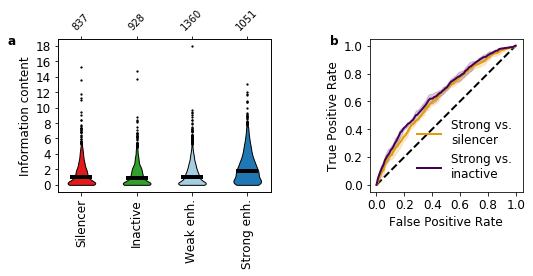

Figure 3--figure supplement 1:


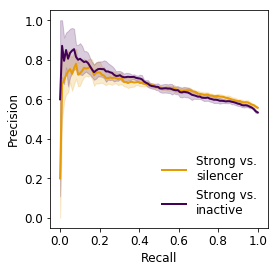

In [17]:
# Fit logistic regression models
entropy_clf = LogisticRegression()
entropy_clf, entropy_tpr_list, entropy_prec_list, entropy_f1_list = modeling.train_estimate_variance(entropy_clf, cv, wt_entropy_df.loc[silencer_modeling_mask, "entropy"], labels_with_silencer, xaxis, positive_cutoff=0)

inactive_entropy_clf = LogisticRegression()
inactive_entropy_clf, inactive_entropy_tpr_list, inactive_entropy_prec_list, inactive_entropy_f1_list = modeling.train_estimate_variance(inactive_entropy_clf, cv, wt_entropy_df.loc[inactive_modeling_mask, "entropy"], labels_with_inactive, xaxis, positive_cutoff=0)

# Setup figures
fig, ax_list = plot_utils.setup_multiplot(2, sharex=False, sharey=False)
fig_pr, ax_pr = plt.subplots()

# 3a: violin plot of information content
print("Information content for each class:")
display(wt_entropy_grouper["entropy"].describe())

ax = ax_list[0]
fig = plot_utils.violin_plot_groupby(wt_entropy_grouper["entropy"], "Information content", class_names=wt_activity_names_oneline, class_colors=color_mapping, figax=(fig, ax))
plot_utils.rotate_ticks(ax.get_xticklabels())
ax.set_yticks(np.arange(0, wt_entropy_df["entropy"].max() + 1, 2))
plot_utils.add_letter(ax, -0.2, 1.03, "a")

# Add ticks above to show the n
ax_twin = ax.twiny()
ax_twin.set_xticks(ax.get_xticks())
ax_twin.set_xlim(ax.get_xlim())
ax_twin.set_xticklabels(wt_activity_count, fontsize=10, rotation=45)

# Statistics for differences in information content
ustat, pval = stats.mannwhitneyu(wt_entropy_grouper["entropy"].get_group("Strong enhancer"), wt_entropy_grouper["entropy"].get_group("Silencer"), alternative="two-sided")
print(f"Strong enhancers and silencers have the same information content, Mann-Whitney U test p = {pval:.0e} U = {ustat:.2f}")
ustat, pval = stats.mannwhitneyu(wt_entropy_grouper["entropy"].get_group("Strong enhancer"), wt_entropy_grouper["entropy"].get_group("Inactive"), alternative="two-sided")
print(f"Strong enhancers and inactive sequences have the same information content, Mann-Whitney U test p = {pval:.0e}, U = {ustat:.2f}")

# 3b: ROC and PR curves with information content vs. two classes
model_data = [
    (entropy_tpr_list, entropy_prec_list, "Strong vs.\nsilencer", "#E69B04"),
    (inactive_entropy_tpr_list, inactive_entropy_prec_list, "Strong vs.\ninactive", plot_utils.set_color(1))
]

model_tprs, model_precs, model_names, model_colors = zip(*model_data)
ax = ax_list[1]

# Plot the models
_, model_aurocs, model_aurocs_std, model_auprs, model_auprs_std = plot_utils.roc_pr_curves(
    modeling_xaxis, model_tprs, model_precs, model_names, model_colors=model_colors,
    figax=([fig, fig_pr], [ax, ax_pr])
)
ax.set_xticks(np.linspace(0, 1, 6))
plot_utils.add_letter(ax, -0.2, 1.03, "b")

# Display model metrics
print("Model metrics:")
for name, auroc, auroc_std, aupr, aupr_std in zip(model_names, model_aurocs, model_aurocs_std, model_auprs, model_auprs_std):
    print(f"{name}\tAUROC={auroc:.3f}+/-{auroc_std:.3f}\tAUPR={aupr:.3f}+/-{aupr_std:.3f}")
    
print("Figure 3:")
fig.tight_layout()
display(fig)
print("Figure 3--figure supplement 1:")
display(fig_pr)
plt.close()
plt.close()

## Strong enhancers require high information content but not NRL motifs

Our results show that except for CRX, none of the lineage-defining motifs occur in a majority of strong enhancers. However, all sequences were tested in reporter constructs with the _Rho_ promoter, which contains an NRL motif and three CRX motifs [@bib9; @bib47]. Since NRL is a key co-regulator with CRX in rod photoreceptors, we tested whether strong enhancers generally require NRL, which would be inconsistent with our TF diversity hypothesis. We removed the NRL motif by recloning our MPRA library without the basal _Rho_ promoter. If strong enhancers require an NRL motif for high activity, then only CRX-targeted sequences with NRL motifs will drive reporter expression. If information content (i.e. total motif content and diversity) is the primary determinant of strong enhancers, only CRX-targeted sequences with sufficient motif diversity, measured by information content, will drive reporter expression regardless of whether or not NRL motifs are present.

We replaced the _Rho_ promoter with a minimal 23 bp polylinker sequence between our libraries and _DsRed_, and repeated the MPRA ([Figure 1—figure supplement 1](#fig1s1), [Supplementary file 3](#supp3)). CRX-targeted sequences were designated as ‘autonomous’ if they retained activity in the absence of the _Rho_ promoter (log~2~(RNA/DNA) > 0, Materials and methods). We found that 90% of autonomous sequences are from the enhancer class, while less than 3% of autonomous sequences are from the silencer class ([Figure 4a](#fig4)). This confirms that the distinction between silencers and enhancers does not depend on the _Rho_ promoter, which is consistent with our previous finding that CRX-targeted silencers repress other promoters [@bib32; @bib86]. However, while most autonomous sequences are enhancers, only 39% of strong enhancers and 9% of weak enhancers act autonomously. Consistent with a role for information content, autonomous strong enhancers have higher information content (Mann-Whitney U test p = 4 × 10^–8^, [Figure 4b](#fig4)) and higher predicted CRX occupancy (Mann-Whitney U test p = 9 × 10^–12^, [Figure 4c](#fig4)) than non-autonomous strong enhancers. We found no evidence that specific lineage-defining motifs are required for autonomous activity, including NRL, which is present in only 25% of autonomous strong enhancers ([Figure 4d](#fig4)). Similarly, NRL ChIP-seq binding [@bib23] occurs more often among autonomous strong enhancers (41% vs. 19%, Fisher’s exact test p = 2 × 10^–14^, odds ratio = 3.0), yet NRL binding still only accounts for a minority of these sequences. We thus conclude that strong enhancers require high information content, rather than any specific lineage-defining motifs.

Correlation between WT activity with Rho vs. Polylinker:
PCC = 0.338
SCC = 0.359
n = 4751
Fraction of autonomous sequences belonging to each activity class:


Strong enhancer    0.693103
Weak enhancer      0.208621
Inactive           0.070690
Silencer           0.027586
Name: group_name_WT, dtype: float64

Fraction of each activity class that has autonomous activity:


group_name_WT
Silencer           0.019394
Inactive           0.044565
Weak enhancer      0.090705
Strong enhancer    0.387657
Name: autonomous_activity, dtype: float64

Information content of autonomous and non-autonomous strong enhancers:


count      mean       std       min       25%       50%  \
autonomous_activity                                                            
False                635.0  2.073301  1.964160  0.000173  0.488725  1.624789   
True                 402.0  2.888074  2.424544  0.000346  0.990757  2.272392   

                          75%        max  
autonomous_activity                       
False                3.026204  11.747577  
True                 4.401275  13.082139

Autonomous and non-autonomous strong enhancers have the same information content, Mann-Whitney U test p=4e-08, U=101739.00
Predicted CRX occupancy of autonomous and non-autonomous strong enhancers:


count     mean       std       min       25%       50%  \
autonomous_activity                                                           
False                635.0  2.34943  1.154518  0.003694  1.471752  2.255551   
True                 402.0  2.83343  1.127028  0.015596  2.062315  2.858271   

                          75%       max  
autonomous_activity                      
False                3.075332  7.368500  
True                 3.554521  5.852791

Autonomous and non-autonomous strong enhancers have the same predicted CRX occupancy, Mann-Whitney U test p=9e-12, U=95541.00
Strong enhancers with autonomous and non-autonomous activity vs. NRL bound and unbound:


nrl_bound            False  True 
autonomous_activity              
False                  513    122
True                   236    166

Fisher's exact test that NRL binding and strong enhancer autonomous activity are independent, p=2e-14, odds ratio=3.0


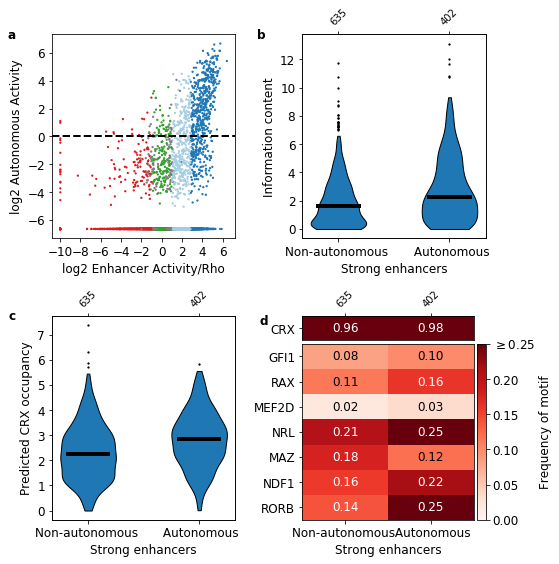

In [18]:
# Keep sequences where the WT and Polylinker were both measured
poly_measured_mask = activity_df[["expression_log2_WT", "expression_log2_POLY"]].notna().all(axis=1)
activity_poly_df = activity_df[poly_measured_mask]
wt_occupancy_poly_df = wt_occupancy_df[poly_measured_mask]
wt_entropy_poly_df = wt_entropy_df[poly_measured_mask]

# Setup the figure
fig, ax_list = plot_utils.setup_multiplot(4, sharex=False, sharey=False)
ax_list = ax_list.flatten()

# 4a: scatterplot of Rho vs. Polylinker
ax = ax_list[0]
print("Correlation between WT activity with Rho vs. Polylinker:")
fig, ax = plot_utils.scatter_with_corr(activity_poly_df["expression_log2_WT"], activity_poly_df["expression_log2_POLY"], "log2 Enhancer Activity/Rho", "log2 Autonomous Activity", colors=activity_poly_df["plot_color_WT"], xticks=rho_ticks, figax=(fig, ax))
ax.axhline(0, color="k", linestyle="--")
plot_utils.add_letter(ax, -0.2, 1.03, "a")

# Display some numbers for the manuscript
print("Fraction of autonomous sequences belonging to each activity class:")
display(activity_poly_df.loc[activity_poly_df["autonomous_activity"], "group_name_WT"].value_counts(normalize=True))

print("Fraction of each activity class that has autonomous activity:")
display(activity_poly_df.groupby("group_name_WT")["autonomous_activity"].apply(lambda x: x.sum() / len(x)))

# Information content of strong autonomous vs. non-autonomous
# Set up grouping
strong_enh_poly_mask = activity_poly_df["group_name_WT"].str.contains("Strong")
strong_enh_poly_mask = strong_enh_poly_mask & strong_enh_poly_mask.notna()
autonomous_occ_grouper = wt_occupancy_poly_df[strong_enh_poly_mask].groupby(activity_poly_df.loc[strong_enh_poly_mask, "autonomous_activity"])
autonomous_entropy_grouper = wt_entropy_poly_df[strong_enh_poly_mask].groupby(activity_poly_df.loc[strong_enh_poly_mask, "autonomous_activity"])

# Set up for plotting
strong_color = color_mapping["Strong enhancer"]
autonomous_names = ["Non-autonomous ", " Autonomous"]
autonomous_counts = [len(i) for i in autonomous_occ_grouper.groups.values()]

# Do stats for difference in IC
print("Information content of autonomous and non-autonomous strong enhancers:")
display(autonomous_entropy_grouper["entropy"].describe())
ustat, pval = stats.mannwhitneyu(*[j for i, j in autonomous_entropy_grouper["entropy"]], alternative="two-sided")
print(f"Autonomous and non-autonomous strong enhancers have the same information content, Mann-Whitney U test p={pval:.0e}, U={ustat:.2f}")

# 4b: Make the plot
ax = ax_list[1]
fig = plot_utils.violin_plot_groupby(autonomous_entropy_grouper["entropy"], "Information content", class_names=autonomous_names, class_colors=[strong_color]*2, figax=(fig, ax))
ax.set_xlabel("Strong enhancers")
# Add ticks for the n
ax_twin = ax.twiny()
ax_twin.set_xticks(ax.get_xticks())
ax_twin.set_xlim(ax.get_xlim())
ax_twin.set_xticklabels(autonomous_counts, fontsize=10, rotation=45)
plot_utils.add_letter(ax, -0.2, 1.03, "b")

# Differences in CRX occupancy
print("Predicted CRX occupancy of autonomous and non-autonomous strong enhancers:")
display(autonomous_occ_grouper["CRX"].describe())
ustat, pval = stats.mannwhitneyu(*[j for i, j in autonomous_occ_grouper["CRX"]], alternative="two-sided")
print(f"Autonomous and non-autonomous strong enhancers have the same predicted CRX occupancy, Mann-Whitney U test p={pval:.0e}, U={ustat:.2f}")

# 4c
ax = ax_list[2]
fig = plot_utils.violin_plot_groupby(autonomous_occ_grouper["CRX"], "Predicted CRX occupancy", class_names=autonomous_names, class_colors=[strong_color]*2, figax=(fig, ax))
ax.set_xlabel("Strong enhancers")
ax.set_yticks(np.arange(8))
# Add ticks for the n
ax_twin = ax.twiny()
ax_twin.set_xticks(ax.get_xticks())
ax_twin.set_xlim(ax.get_xlim())
ax_twin.set_xticklabels(autonomous_counts, fontsize=10, rotation=45)
plot_utils.add_letter(ax, -0.2, 1.03, "c")

# Differences in motif frequencies
autonomous_motif_freq_df = autonomous_occ_grouper.apply(lambda x: (x > occupied_cutoff).sum() / len(x))
# Sort by the feature importance in the logistic model
autonomous_motif_freq_df = autonomous_motif_freq_df.iloc[:, feature_order]

# 4d: Make heatmakt, but put CRX separate
ax = ax_list[3]
autonomous_motif_freq_no_crx_df = autonomous_motif_freq_df.drop(columns="CRX") 
vmax = 0.25
thresh = vmax / 2
heatmap = ax.imshow(autonomous_motif_freq_no_crx_df.T, aspect="auto", cmap="Reds", vmax=vmax, vmin=0)
ax.set_xlabel("Strong enhancers")
ax.set_xticks(np.arange(len(autonomous_motif_freq_no_crx_df)))
ax.set_xticklabels(autonomous_names)
ax.set_yticks(np.arange(len(autonomous_motif_freq_no_crx_df.columns)))
ax.set_yticklabels(autonomous_motif_freq_no_crx_df.columns)
plot_utils.annotate_heatmap(ax, autonomous_motif_freq_no_crx_df, thresh)

# Add colorbar
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad="2%")
colorbar = fig.colorbar(heatmap, cax=cax, label="Frequency of motif")
ticks = cax.get_yticks()
ticks = [f"{i:.2f}" for i in ticks]
ticks[-1] = r"$\geq$" + ticks[-1]
cax.set_yticklabels(ticks)

# Add CRX
cax = divider.append_axes("top", size="14%", pad="2%")
heatmap = cax.imshow(autonomous_motif_freq_df["CRX"].to_frame().T, aspect="auto", cmap="Reds", vmax=vmax, vmin=0)
cax.set_xticks([])
cax.set_yticks([0])
cax.set_yticklabels(["CRX"])
plot_utils.annotate_heatmap(cax, autonomous_motif_freq_df["CRX"].to_frame(), thresh)
plot_utils.add_letter(cax, -0.2, 1.03, "d")

# Add ticks for the n
cax.xaxis.tick_top()
cax.set_xticks(ax.get_xticks())
cax.set_xlim(ax.get_xlim())
cax.set_xticklabels(autonomous_counts, fontsize=10, rotation=45)

# Test relationship between NRL binding and strong enhancer autonomous activity
print("Strong enhancers with autonomous and non-autonomous activity vs. NRL bound and unbound:")
nrl_chip_vs_autonomous = activity_poly_df[strong_enh_poly_mask].groupby("autonomous_activity")["nrl_bound"].value_counts().unstack()
display(nrl_chip_vs_autonomous)
oddsratio, pval = stats.fisher_exact(nrl_chip_vs_autonomous)
print(f"Fisher's exact test that NRL binding and strong enhancer autonomous activity are independent, p={pval:.0e}, odds ratio={oddsratio:.1f}")
fig.tight_layout()
display(fig)
plt.close()

## TF motifs contribute independently to strong enhancers

Our results indicate that information content distinguishes strong enhancers from silencers and inactive sequences. Information content only takes into account the total number and diversity of motifs in a sequence and not any potential interactions between them. The classification success of information content thus suggests that each TF motif will contribute independently to enhancer activity. We tested this prediction with CRX-targeted sequences where all CRX motifs were abolished by point mutation ([Supplementary file 3](#supp3)). Consistent with our previous work [@bib85], mutating CRX motifs causes the activities of both enhancers and silencers to regress toward basal levels (Pearson’s _r_ = 0.608, [Figure 5a](#fig5)), indicating that most enhancers and silencers show some dependence on CRX. However, 40% of wild-type strong enhancers show low CRX dependence and remain strong enhancers with their CRX motifs abolished. Although strong enhancers with high and low CRX dependence have similar wild-type information content ([Figure 5b](#fig5)), strong enhancers with low CRX dependence have lower predicted CRX occupancy than those with high CRX dependence (Mann-Whitney U test p = 2 × 10^–9^, [Figure 5c](#fig5)), and also have higher ‘residual’ information content (i.e. information content without CRX motifs, Mann-Whitney U test p = 1 × 10^–7^, [Figure 5d](#fig5)). Low CRX dependence sequences have an average of 1.5 residual bits, which corresponds to three motifs for two TFs, while high CRX dependence sequences have an average of 1.0 residual bits, which corresponds to two motifs for two TFs ([Figure 5e](#fig5)).

Correlation between WT and MUT activities:
PCC = 0.608
SCC = 0.706
n = 4123
Information content of strong enhancers with different mutant activities:


count      mean       std       min       25%       50%  \
group_name_MUT                                                            
False           586.0  2.321663  2.067846  0.000346  0.641760  1.849581   
True            344.0  2.857066  2.411316  0.001591  1.145032  2.413095   

                     75%        max  
group_name_MUT                       
False           3.333561  11.676515  
True            3.969305  13.082139

Predicted CRX occupancy of strong enhancers with different mutant activities:


count      mean       std       min       25%       50%  \
group_name_MUT                                                            
False           586.0  2.876820  1.069855  0.927761  2.085474  2.857976   
True            344.0  2.454016  1.009155  0.964684  1.626097  2.338718   

                     75%       max  
group_name_MUT                      
False           3.575210  7.368500  
True            3.110073  5.730406

Strong enhancers that remain strong vs. do not have the same CRX occupancy, Mann-Whitney U test p=2e-09, U=124411.00
Residual information content of strong enhancers with different mutant activities:


count      mean       std       min       25%       50%  \
group_name_MUT                                                            
False           586.0  1.026129  1.283253  0.000001  0.097540  0.493644   
True            344.0  1.536551  1.638575  0.000136  0.264872  1.046836   

                     75%       max  
group_name_MUT                      
False           1.472322  7.129248  
True            2.338690  9.819172

Strong enhancers that stay strong vs. do not have the same residual information content, Mann-Whitney U test p=1e-07, U=79938.00


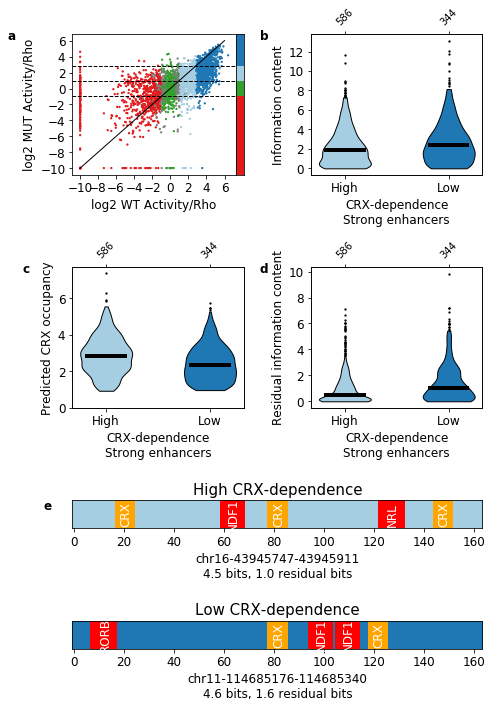

In [19]:
# Helper functions to visualize sequence
def hex_to_rgb(hexcode):
    return tuple(int(hexcode[i:i+2], 16) / 255 for i in (1, 3, 5))

strong_color_rgb = hex_to_rgb(strong_color)
weak_color_rgb = hex_to_rgb(color_mapping["Weak enhancer"])
crx_color = mpl.colors.to_rgb("orange")
other_tf_color = mpl.colors.to_rgb("red")

def visualize_sequence(seq_id, ax, title, below_text, basecolor):
    seq_occupancy_df = predicted_occupancy.total_landscape(all_seqs[seq_id], ewms, mu)
    visual = np.full(((len(seq_occupancy_df), 3)), basecolor) # (number of positions, RGB values)
    text_mapping = [] # (name of TF, center position of motif)
    # Loop over each TF, identify motifs, and fill in the representation with the predicted occupancy for the full motif
    for col in seq_occupancy_df:
        tf, orient = col.split("_")
        for motif_start, occ in seq_occupancy_df[col].iteritems():
            if occ > occupied_cutoff:
                motif_end = motif_start + motif_len[tf]
                # Check and make sure all positions of the motif are zeros
                if (visual[motif_start:motif_end] != basecolor).all(axis=1).any():
                    print(f"Error, motif already in the range {motif_start}-{motif_end}! Skipping.")
                else:
                    color = crx_color if tf == "CRX" else other_tf_color
                    visual[motif_start:motif_end] = color
                    text_mapping.append((tf, (motif_start + motif_end) / 2))
        
    heatmap = ax.imshow(visual[np.newaxis, :], aspect="auto", cmap="Reds")
    ax.set_yticks([])
    # Add text showing which motif is where
    for tf, x in text_mapping:
        ax.text(x, 0, tf, ha="center", va="center", color="white", rotation=90)

    ax.set_title(title)
    ax.set_xlabel(below_text)
    
    return ax, heatmap

# Setup for sequences where both WT and MUT was measured
wt_mut_mask = activity_df["wt_vs_mut_log2"].notna()
activity_wt_mut_measured_df = activity_df[wt_mut_mask]
wt_occ_mut_measured_df = wt_occupancy_df[wt_mut_mask]
wt_entropy_mut_measured_df = wt_entropy_df[wt_mut_mask]
mut_entropy_measured_df = mut_entropy_df[wt_mut_mask]

# Figure setup
gs_kw = dict(height_ratios=[5, 5, 1, 1])
fig, ax_list = plt.subplots(nrows=4, ncols=2, figsize=(7, 10), gridspec_kw=gs_kw)
gs = ax_list[0, 0].get_gridspec()
for row in [2, 3]:
    for ax in ax_list[row]:
        ax.remove()
    
axstrong = fig.add_subplot(gs[2, :])
axweak = fig.add_subplot(gs[3, :])

# 5a: Scatter plot of WT and MUT activities
ax = ax_list[0, 0]
print("Correlation between WT and MUT activities:")
fig, ax = plot_utils.scatter_with_corr(activity_wt_mut_measured_df["expression_log2_WT"], activity_wt_mut_measured_df["expression_log2_MUT"],
                                      "log2 WT Activity/Rho", "log2 MUT Activity/Rho", colors=activity_wt_mut_measured_df["plot_color_WT"],
                                      xticks=rho_ticks, yticks=rho_ticks, figax=(fig, ax))
# Plot y = x line
ax.plot(rho_ticks, rho_ticks, color="black", linewidth=1)
# Show cutoffs for different classes
strong_cutoff = activity_df.groupby("group_name_WT")["expression_log2_WT"].get_group("Strong enhancer").min()
for line in [-1, 1, strong_cutoff]:
    ax.axhline(line, color="black", linestyle="--", linewidth=1)
    
# Add colorbar to show the cutoffs
divider = make_axes_locatable(ax)
color_ax = divider.append_axes("right", size="5%")
color_ax.set_ylim(ax.get_ylim())
color_ax.barh([(-1 - ax.get_ylim()[0]) / 2 + ax.get_ylim()[0], 0, (strong_cutoff - 1) / 2 + 1, (ax.get_ylim()[1] - strong_cutoff) / 2 + strong_cutoff], # Midpoint of the bars
             [1, 1, 1, 1], # Bar height
             [-1 - ax.get_ylim()[0], 2, strong_cutoff - 1, ax.get_ylim()[1] - strong_cutoff], # Bar width
             color=color_mapping)
color_ax.set_xticks([])
color_ax.set_yticks([])
color_ax.set_xlim(right=1)

plot_utils.add_letter(ax, -0.35, 1.03, "a")

# Setup strong enhancer->mutant activity groupings
strong_mask = activity_wt_mut_measured_df["group_name_WT"].str.contains("Strong")
strong_mask = strong_mask & strong_mask.notna()
activity_strong_df = activity_wt_mut_measured_df[strong_mask]

# Group the data based on CRX-dependence (whether or not it stay strong) and name the groups accordingly
stay_strong_mask = activity_strong_df["group_name_MUT"].str.contains("Strong") & activity_strong_df["group_name_MUT"].notna()
wt_occ_strong_grouper = wt_occ_mut_measured_df[strong_mask].groupby(stay_strong_mask)
wt_entropy_strong_grouper = wt_entropy_mut_measured_df[strong_mask].groupby(stay_strong_mask)
strong_mutant_names = wt_entropy_strong_grouper["entropy"].count().rename({False: "High", True: "Low"}).index.values.tolist()
strong_mutant_counts = wt_entropy_strong_grouper["entropy"].count().astype(int).values

# Differences in information content
print("Information content of strong enhancers with different mutant activities:")
display(wt_entropy_strong_grouper["entropy"].describe())

# 5b: Information content
ax = ax_list[0, 1]
fig = plot_utils.violin_plot_groupby(wt_entropy_strong_grouper["entropy"], "Information content", class_names=strong_mutant_names, class_colors=color_mapping[["Weak enhancer", "Strong enhancer"]], figax=(fig, ax))
ax.set_xlabel("CRX-dependence\nStrong enhancers")
ax.set_yticks(np.arange(0, 13, 2))
ax_twin = ax.twiny()
ax_twin.set_xticks(ax.get_xticks())
ax_twin.set_xlim(ax.get_xlim())
ax_twin.set_xticklabels(strong_mutant_counts, fontsize=10, rotation=45)
plot_utils.add_letter(ax, -0.25, 1.03, "b")

# Differences in predicted CRX occupancy of strong enhancers with different CRX-dependences
print("Predicted CRX occupancy of strong enhancers with different mutant activities:")
display(wt_occ_strong_grouper["CRX"].describe())
ustat, pval = stats.mannwhitneyu(*[j for i, j in wt_occ_strong_grouper["CRX"]], alternative="two-sided")
print(f"Strong enhancers that remain strong vs. do not have the same CRX occupancy, Mann-Whitney U test p={pval:.0e}, U={ustat:.2f}")

# 5c: predicted CRX occupancy
ax = ax_list[1, 0]
fig = plot_utils.violin_plot_groupby(wt_occ_strong_grouper["CRX"], "Predicted CRX occupancy", class_names=strong_mutant_names, class_colors=color_mapping[["Weak enhancer", "Strong enhancer"]], figax=(fig, ax))
ax.set_xlabel("CRX-dependence\nStrong enhancers")
ax.set_yticks(np.arange(0, 8, 2))
ax_twin = ax.twiny()
ax_twin.set_xticks(ax.get_xticks())
ax_twin.set_xlim(ax.get_xlim())
ax_twin.set_xticklabels(strong_mutant_counts, fontsize=10, rotation=45)
plot_utils.add_letter(ax, -0.25, 1.03, "c")

# Differences in redisual IC
print("Residual information content of strong enhancers with different mutant activities:")
mut_entropy_strong_grouper = mut_entropy_measured_df[strong_mask].groupby(stay_strong_mask)
display(mut_entropy_strong_grouper["entropy"].describe())
ustat, pval = stats.mannwhitneyu(*[j for i, j in mut_entropy_strong_grouper["entropy"]], alternative="two-sided")
print(f"Strong enhancers that stay strong vs. do not have the same residual information content, Mann-Whitney U test p={pval:.0e}, U={ustat:.2f}")

# 5d: Residual information content
ax = ax_list[1, 1]
fig = plot_utils.violin_plot_groupby(mut_entropy_strong_grouper["entropy"], "Residual information content", class_names=strong_mutant_names, class_colors=color_mapping[["Weak enhancer", "Strong enhancer"]], figax=(fig, ax))
ax.set_xlabel("CRX-dependence\nStrong enhancers")
ax.set_yticks(np.arange(0, 11, 2))
ax_twin = ax.twiny()
ax_twin.set_xticks(ax.get_xticks())
ax_twin.set_xlim(ax.get_xlim())
ax_twin.set_xticklabels(strong_mutant_counts, fontsize=10, rotation=45)
plot_utils.add_letter(ax, -0.25, 1.03, "d")

# 5e Visualize the two depresentative sequences
ax = axstrong
become_weak_example_id = "chr16-43945747-43945911_UPPE"
become_weak_text = become_weak_example_id.split("_")[0] + "\n" + f"{wt_entropy_df.loc[become_weak_example_id, 'entropy']:.1f}" + " bits, " + f"{mut_entropy_df.loc[become_weak_example_id, 'entropy']:.1f}" + " residual bits"
ax, become_weak_visual = visualize_sequence(become_weak_example_id + "_WT", ax, "High CRX-dependence", become_weak_text, weak_color_rgb)
plot_utils.add_letter(ax, -0.05, 1.03, "e")

ax = axweak
stay_strong_example_id = "chr11-114685176-114685340_CPPE"
stay_strong_text = stay_strong_example_id.split("_")[0] + "\n" + f"{wt_entropy_df.loc[stay_strong_example_id, 'entropy']:.1f}" + " bits, " + f"{mut_entropy_df.loc[stay_strong_example_id, 'entropy']:.1f}" + " residual bits"
ax, stay_strong_visual = visualize_sequence(stay_strong_example_id + "_WT", ax, "Low CRX-dependence", stay_strong_text, strong_color_rgb)

fig.tight_layout()
display(fig)
plt.close()

Strong enhancers with low and high CRX dependence have similar wild-type information content and similar total predicted occupancy ([Figure 5b and e](#fig5)). As a result, sequences with more CRX motifs have fewer motifs for other TFs, suggesting that there is no evolutionary pressure for enhancers to contain additional motifs beyond the minimum amount of information content required to be active. To test this idea, we calculated the minimum number and diversity of motifs necessary to specify a relatively unique location in the genome [@bib87] and found that a 164 bp sequence only requires five motifs for three TFs (Materials and methods). These motif requirements can be achieved in two ways with similar information content that differ only in the quantitative number of motifs for each TF. In other words, the number of motifs for any particular TF is not important so long as there is sufficient information content. Taken together, we conclude that each TF motif provides an independent contribution toward specifying strong enhancers.

# Discussion

Many regions in the genome are bound by TFs and bear the epigenetic hallmarks of active _cis_-regulatory sequences, yet fail to exhibit _cis_-regulatory activity when tested directly. The discrepancy between measured epigenomic state and _cis_-regulatory activity indicates that enhancers and silencers consist of more than the minimal sequence features necessary to recruit TFs and chromatin-modifying factors. Our results show that enhancers, silencers, and inactive sequences in developing photoreceptors can be distinguished by their motif content, even though they are indistinguishable by CRX binding or chromatin accessibility. We show that both enhancers and silencers contain more TF motifs than inactive sequences, and that enhancers also contain more diverse sets of motifs for lineage-defining TFs. These differences are captured by our measure of information content. Information content, as a single metric, identifies strong enhancers nearly as well as an unbiased set of 2080 non-redundant 6-mers used for an SVM, indicating that a simple measure of motif number and diversity can capture the key sequence features that distinguish enhancers from other sequences that lie in open chromatin.

The results of our information content classifier are consistent with the TF collective model of enhancers [@bib39; @bib78]: globally, active enhancers are specified by the combinatorial action of lineage-defining TFs with little constraint on which motifs must co-occur. We show that CRX-targeted enhancers are distinguished from inactive CRX-targeted sequences by a larger, more diverse collection of TF motifs, and not any specific combination of motifs. This indicates that enhancers are active because they have acquired the necessary number of TF binding motifs, and not because they are defined by a strict regulatory grammar. Sequences with fewer motifs may be bound by CRX and reside within open chromatin, but they lack sufficient TF binding for activity. Such loose constraints would facilitate the de novo emergence of tissue-specific enhancers and silencers over evolution and explain why critical cell type-specific TF interactions, such as CRX and NRL in rod photoreceptors, occur at only a minority of the active enhancers in that cell type [@bib28; @bib32; @bib85].

Like enhancers, CRX-targeted silencers require higher motif content and are dependent on CRX motifs, but they lack the TF diversity of enhancers. The lack of TF diversity in silencers parallels the architecture of signal-responsive _cis_-regulatory sequences, which are silencers in the absence of a signal and require multiple activators for induction [@bib4]. Consistent with this, we previously showed using synthetic sequences that high occupancy of CRX alone is sufficient to encode silencers while the addition of a single NRL motif converts synthetic silencers to enhancers, and that genomic sequences with very high CRX motif content repress a basal promoter that lacks NRL motifs [@bib86]. We found that photoreceptor genes which are de-repressed upon loss of CRX are located near _cis_-regulatory sequences with high CRX motif content, and that genes near regions that are bound only by CRX are expressed at lower levels than genes near regions co-bound by CRX and NRL [@bib86]. In the current study, we find that silencers in our MPRA library are more likely to occur near de-repressed photoreceptor genes, while strong enhancers are enriched near genes that lose expression in _Crx^-/-^_ retina. These findings suggest that the low TF diversity and high CRX motif content that characterize silencers in our MPRA library are also important for silencing in the genome.

The contrast in motif diversity between enhancers and silencers that we observe could explain how CRX achieves selective activation and repression of its target genes in multiple cell types and across developmental time points [@bib60; @bib72]. CRX itself is required for silencing, and we previously showed that some silencers become active enhancers in _Crx^-/-^_ retina [@bib86]. The mechanism of CRX-based silencing is unknown, however CRX cooperates with other TFs that can sometimes act as repressors of cell type-specific genes [@bib7; @bib65; @bib84], while other repressors can directly inhibit activation by CRX or its co-activators [@bib12; @bib26; @bib57; @bib75]. In _Drosophila_ photoreceptors, selective silencing of opsin genes is controlled by cell type-specific expression of a repressor, Dve, which acts on the same K50 homeodomain-binding sites as a universally expressed activator, Otd, a homolog of CRX [@bib70]. Other transcriptional activators selectively act as repressors in the same cell type. GATA-1 represses the _GATA-_2 promoter by displacing CREB-binding protein (CBP), while at other genes GATA-1 binds CBP to activate transcription [@bib21]. Selective repression by GATA-1 is also mediated by chromatin occupancy levels and interaction with co-regulators [@bib38], which is consistent with our finding that sequence context enables a TF to both activate and repress genes in the same cell type.

Given the central role of CRX in selectively regulating genes in multiple closely related cell types [@bib60], we speculate that CRX-targeted silencers may contain sufficient information to act as enhancers in other cell types in which a different set of co-activating TFs are expressed. This hypothesis would be consistent with the finding that many silencers are enhancers in other cell types [@bib11; @bib20; @bib61]. Our work suggests that characterizing sequences by their motif information content offers a way to identify these different classes of _cis_-regulatory sequences in the genome.

# Materials and methods

table: Key resources table
:::
| Reagent type (species) or resource                          | Designation                           | Source or reference                                | Identifiers                                                                        | Additional information                   |
| ----------------------------------------------------------- | ------------------------------------- | -------------------------------------------------- | ---------------------------------------------------------------------------------- | ---------------------------------------- |
| Strain, strain background (_Mus musculus_, male and female) | CD-1                                  | Charles River                                      | Strain code 022                                                                    |                                          |
| Recombinant DNA reagent                                     | Library1                              | This paper                                         |                                                                                    | Listed in [Supplementary file 1](#supp1) |
| Recombinant DNA reagent                                     | Library2                              | This paper                                         |                                                                                    | Listed in [Supplementary file 2](#supp2) |
| Recombinant DNA reagent                                     | pJK01_Rhominprox-DsRed                | [@bib47]                                           | AddGene plasmid # 173,489                                                          |                                          |
| Recombinant DNA reagent                                     | pJK03\__Rho_basal\__DsRed             | [@bib47]                                           | AddGene plasmid # 173,490                                                          |                                          |
| Sequence-based reagent                                      | Primers                               | IDT                                                |                                                                                    | Listed in [Supplementary file 6](#supp6) |
| Commercial assay or kit                                     | Monarch PCR Cleanup Kit               | New England Biolabs                                | T1030S                                                                             |                                          |
| Commercial assay or kit                                     | Monarch DNA Gel Extraction Kit        | New England Biolabs                                | T1020L                                                                             |                                          |
| Commercial assay or kit                                     | TURBO DNA-free                        | Invitrogen                                         | AM1907                                                                             |                                          |
| Commercial assay or kit                                     | SuperScript III Reverse Transcriptase | Invitrogen                                         | 18080044                                                                           |                                          |
| Software, algorithm                                         | Bedtools                              | <https://bedtools.readthedocs.io/en/latest/>       | RRID:[SCR_006646](https://identifiers.org/RRID/RRID:SCR_006646)                    |                                          |
| Software, algorithm                                         | MEME Suite                            | <https://meme-suite.org/>                          | RRID:[SCR_001783](https://identifiers.org/RRID/RRID:SCR_001783)                    |                                          |
| Software, algorithm                                         | ShapeMF                               | <https://github.com/h-samee/shape-motif>, [@bib74] | DOI:[10.1016/j.cels.2018.12.001](https://doi.org/10.1016/j.cels.2018.12.001)       |                                          |
| Software, algorithm                                         | Numpy                                 | <https://numpy.org/>                               | DOI:[10.1038/s41586-020-2649-2](https://doi.org/10.1038/s41586-020-2649-2)         |                                          |
| Software, algorithm                                         | Scipy                                 | <https://www.scipy.org/>                           | DOI:[10.1038/s41592-019-0686-2](https://doi.org/10.1038/s41592-019-0686-2)         |                                          |
| Software, algorithm                                         | Pandas                                | <https://pandas.pydata.org/>                       | DOI:[10.5281/zenodo.3509134](https://doi.org/10.5281/zenodo.3509134)               |                                          |
| Software, algorithm                                         | Matplotlib                            | <https://matplotlib.org/>                          | DOI:[10.5281/zenodo.1482099](https://doi.org/10.5281/zenodo.1482099)               |                                          |
| Software, algorithm                                         | Logomaker                             | <https://github.com/jbkinney/logomaker>, [@bib40]  | DOI:[10.1093/bioinformatics/btz921](https://doi.org/10.1093/bioinformatics/btz921) |                                          |
:::
{#keyresource}

## Library design

CRX ChIP-seq peaks re-processed by [@bib72] were intersected with previously published CRX MPRA libraries [@bib32; @bib85] and one unpublished library to select sequences that had not been previously tested by MPRA. These sequences were scanned for instances of CRX motifs using FIMO version 4.11.2 [@bib3], a p-value cutoff of 2.3 × 10^–3^ (see below), and a CRX PWM derived from an electrophoretic mobility shift assay [@bib49]. We centered 2622 sequences on the highest scoring CRX motif. For 677 sequences without a CRX motif, we instead centered them using the Gibbs sampler from ShapeMF (Github commit abe8421) [@bib73] and a motif size of 10.

For sequences unbound in CRX ChIP-seq but in open chromatin, we took ATAC-seq peaks collected in 8-week FACS-purified rods, green cones, and _Nrl^-/-^_ blue cones [@bib31] and removed sequences that overlapped with CRX ChIP-seq peaks. The remaining sequences were scanned for instances of CRX motifs using FIMO with a p-value cutoff of 2.5 × 10^–3^ and the CRX PWM. Sequences with a CRX motif were kept and the three ATAC-seq data sets were merged together, intersected with H3K27ac and H3K4me3 ChIP-seq peaks collected in P14 retinas [@bib72], and centered on the highest scoring CRX motifs. We randomly selected 1004 H3K27ac^+^H3K4me3^-^ sequences and 541 H3K27ac^+^H3K4me3^+^ to reflect the fact that ~35% of CRX ChIP-seq peaks are H3K4me3^+^. After synthesis of our library, we discovered 11% of these sequences do not actually overlap H3K27ac ChIP-seq peaks (110/1004 of the H3K4me3^-^ group and 60/541 of the H3K4me3^+^ group), but we still included them in the analysis because they contain CRX motifs in ATAC-seq peaks.

All data was converted to mm10 coordinates using the UCSC liftOver tool [@bib22] and processed using Bedtools version 2.27.1 [@bib68]. All sequences in our library design were adjusted to 164 bp and screened for instances of EcoRI, SpeI, SphI, and NotI sites. In total, our library contains 4844 genomic sequences (2622 CRX ChIP-seq peaks with motifs, 677 CRX ChIP-seq peaks without motifs, 1004 CRX^-^ATAC^+^H3K27ac^+^H3K4me3^-^ CRX motifs, and 541 CRX^-^ATAC^+^H3K27ac^+^H3K4me3^+^ CRX motifs), a variant of each sequence with all CRX motifs mutated, 150 scrambled sequences, and a construct for cloning the basal promoter alone.

For sequences centered on CRX motifs, all CRX motifs with a p-value of 2.5 × 10^–3^ or less were mutated by changing the core TAAT to TACT [@bib49] on the appropriate strand, as described previously [@bib32; @bib85]. We then re-scanned sequences and mutated any additional motifs inadvertently created.

To generate scrambled sequences, we randomly selected 150 CRX ChIP-seq peaks spanning the entire range of GC content in the library. We then scrambled each sequence while preserving dinucleotide content as previously described [@bib85]. We used FIMO to confirm that none of the scrambled sequences contain CRX motifs.

We unintentionally used a FIMO p-value cutoff of 2.3 × 10^–3^ to identify CRX motifs in CRX ChIP-seq peaks, rather than the slightly less stringent 2.5 × 10^–3^ cutoff used with ATAC-seq peaks or mutating CRX motifs. Due to this anomaly, there may be sequences centered using ShapeMF that should have been centered on a CRX motif, and these motifs would not have been mutated because CRX motifs were not mutated in sequences centered using ShapeMF. However, any intact CRX motifs would still be captured in the residual information content of the mutant sequence.

## Plasmid library construction

We generated two 15,000 libraries of 230 bp oligonucleotides (oligos) from Agilent Technologies (Santa Clara, CA) through a limited licensing agreement. Our library was split across the two oligo pools, ensuring that both the genomic and mutant forms of each sequence were placed in the same oligo pool ([Supplementary files 1 and 2](#supp1)). Both oligo pools contain all 150 scrambled sequences as an internal control. All sequences were assigned three unique barcodes as previously described [@bib85]. In each oligo pool, the basal promoter alone was assigned 18 unique barcodes. Oligos were synthesized as follows: 5’ priming sequence (GTAGCGTCTGTCCGT)/EcoRI site/Library sequence/SpeI site/C/SphI site/Barcode sequence/NotI site/3’ priming sequence (CAACTACTACTACAG). To clone the basal promoter into barcoded oligos without any upstream _cis_-regulatory sequence, we placed the SpeI site next to the EcoRI site, which allowed us to place the promoter between the EcoRI site and the 3’ barcode.

We cloned the synthesized oligos as previously described by our group [@bib47; @bib86; @bib85]. Specifically, for each oligo pool, we used 50 femtomoles of template and four cycles of PCR in each of multiple 50 µl reactions (New England Biolabs \[NEB], Ipswich, MA) (NEB Phusion) using primers MO563 and MO564 ([Supplementary file 6](#supp6)), 2% DMSO, and an annealing temperature of 57°C. PCR amplicons were purified from a 2% agarose gel (NEB), digested with EcoRI-HF and NotI-HF (NEB), and then cloned into the EagI and EcoRI sites of the plasmid pJK03 with multiple 20 µl ligation reactions (NEB T4 ligase). The libraries were transformed into 5-alpha electrocompetent cells (NEB) and grown in liquid culture. Next, 2 µg of each library was digested with SphI-HF and SpeI-HF (NEB) and then treated with Antarctic phosphatase (NEB).

The _Rho_ basal promoter and _DsRed_ reporter gene was amplified from the plasmid pJK01 using primers MO566 and MO567 ([Supplementary file 6](#supp6)). The Polylinker and _DsRed_ reporter gene was amplified from the plasmid pJK03 using primers MO610 and MO567 ([Supplementary file 6](#supp6)). The Polylinker is a short 23 bp multiple cloning site with no known core promoter motifs. Inserts were purified from a 1% agarose gel (NEB), digested with NheI-HF and SphI-HF (NEB), and cloned into the libraries using multiple 20 µl ligations (NEB T4 ligase). The libraries were transformed into 5-alpha electrocompetent cells (NEB) and grown in liquid culture.

## Retinal explant electroporation

Animal procedures were performed in accordance with a Washington University in St Louis Institutional Animal Care and Use Committee-approved vertebrate animals protocol. Electroporation into retinal explants and RNA extraction was performed as described previously [@bib28; @bib32; @bib47; @bib86; @bib85]. Briefly, retinas were isolated from P0 newborn CD-1 mice and electroporated in a solution with 30 µg library and 30 µg _Rho_-GFP. Electroporated retinas were cultured for 8 days, at which point they were harvested, washed three times with HBSS (ThermoFisher Scientific/Gibco, Waltham, MA), and stored in TRIzol (ThermoFisher Scientific/Invitrogen, Waltham, MA) at –80°C. Five retinas were pooled for each biological replicate and three replicates were performed for each library. RNA was extracted from TRIzol according to manufacturer’s instructions and treated with TURBO DNase (Invitrogen). cDNA was prepared using SuperScript RT III (Invitrogen) with oligo dT primers. Barcodes from both the cDNA and the plasmid DNA pool were amplified for sequencing (described below). The resulting products were mixed at equal concentration and sequenced on the Illumina NextSeq platform. We obtained greater than 1300× coverage across all samples.

_Rho_ libraries were amplified using primers MO574 and MO575 ([Supplementary file 6](#supp6)) for six cycles at an annealing temperature of 66°C followed by 18 cycles with no annealing step (NEB Phusion) and then purified with the Monarch PCR kit (NEB). PCR amplicons were digested using MfeI-HF and SphI-HF (NEB) and ligated to custom-annealed adaptors with PE2 indexing barcodes and phased P1 barcodes ([Supplementary file 6](#supp6)). The final enrichment PCR used primers MO588 and MO589 ([Supplementary file 6](#supp6)) for 20 cycles at an annealing temperature of 66°C (NEB Phusion), followed by purification with the Monarch PCR kit. Polylinker libraries were amplified using primers BC_CRX_Nested_F and BC_CRX_R ([Supplementary file 6](#supp6)) for 30 cycles (NEB Q5) at an annealing temperature of 67°C and then purified with the Monarch PCR kit. Illumina adaptors were then added via two further rounds of PCR. First, P1 indexing barcodes were added using forward primers P1_inner_A through P1_inner_D and reverse primer P1_inner_nested_rev ([Supplementary file 6](#supp6)) for five cycles at an annealing temperature of 55°C followed by five cycles with no annealing step (NEB Q5). PE2 indexing barcodes were then added by amplifying 2 µl of the previous reaction with forward primer P1_outer and reverse primers PE2_outer_SIC69 and PE2_outer_SIC70 ([Supplementary file 6](#supp6)) for five cycles at an annealing temperature of 66°C followed by five cycles with no annealing step (NEB Q5) and then purified with the Monarch PCR kit.

## Data processing

All data processing, statistical analysis, and downstream analyses were performed in Python version 3.6.5 using Numpy version 1.15.4 [@bib24], Scipy version 1.1.0 [@bib82], and Pandas version 0.23.4 [@bib54], and visualized using Matplotlib version 3.0.2 [@bib33] and Logomaker version 0.8 [@bib81]. All statistical analysis used two-sided tests unless noted otherwise.

Sequencing reads were filtered to ensure that the barcode sequence perfectly matched the expected sequence (>93% reads in a sample for the _Rho_ libraries, >86% reads for the Polylinker libraries). For the _Rho_ libraries, barcodes that had less than 10 raw counts in the DNA sample were considered missing and removed from downstream analysis. Barcodes that had less than five raw counts in any cDNA sample were considered present in the input plasmid pool but below the detection limit and thus set to zero in all samples. Barcode counts were normalized by reads per million (RPM) for each sample. Barcode expression was calculated by dividing the cDNA RPM by the DNA RPM. Replicate-specific expression was calculated by averaging the barcodes corresponding to each library sequence. After performing statistical analysis (see below), expression levels were normalized by replicate-specific basal mean expression and then averaged across biological replicates.

For the Polylinker assay, the expected lack of expression of many constructs required different processing. Barcodes that had less than 50 raw counts in the DNA sample were removed from downstream analysis. Barcodes were normalized by RPM for each replicate. Barcodes that had less than 8 RPM in any cDNA sample were set to zero in all samples. cDNA RPM were then divided by DNA RPM as above. Within each biological replicate, barcodes were averaged as above but were not normalized to basal expression because there is no basal construct. Expression values were then averaged across biological replicates. Due to the low expression of scrambled sequences and the lack of a basal construct, we were unable to assess data calibration with the same rigor as above.

## Assignment of activity classes

Activity classes were assigned by comparing expression levels to basal promoter expression levels across replicates. The null hypothesis is that the expression of a sequence is the same as basal levels. Expression levels were approximately log-normally distributed, so we computed the log-normal parameters for each sequence and then performed Welch’s t-test. We corrected for multiple hypotheses using the Benjamini-Hochberg FDR procedure. We corrected for multiple hypotheses in each library separately to account for any potential batch effects between libraries. The log~2~ expression was calculated after adding a pseudocount of 1 × 10^–3^ to every sequence.

Sequences were classified as enhancers if they were twofold above basal and the q-value was below 0.05. Silencers were similarly defined as twofold below basal and q-value less than 0.05. Inactive sequences were defined as within a twofold change and q-value greater than or equal to 0.05. All other sequences were classified as ambiguous and removed from further analysis. We used scrambled sequences to further stratify enhancers into strong and weak enhancers, using the rationale that scrambled sequences give an empirical distribution for the activity of random sequences. We defined strong enhancers as enhancers that are above the 95th percentile of scrambled sequences and all other enhancers as weak enhancers.

For the Polylinker assay, we did not have a basal construct as a reference point. Instead, we defined a sequence to have autonomous activity if the average cDNA barcode counts were higher than average DNA barcode counts, and non-autonomous otherwise. The log~2~ expression was calculated after adding a pseudocount of 1 × 10^–2^ to every sequence.

## RNA-seq analysis

We obtained RNA-seq data from WT and Crx^-/-^ P21 retinas [@bib71] processed into a counts matrix for each gene by [@bib72]. Each sample was normalized by read counts per million and replicates were averaged together. Genes with at least a twofold change between genotypes were considered differentially expressed. We determined which differentially expressed genes are near a member of our library using previously published associations between retinal ATAC-seq peaks and genes [@bib60]. For de-repressed genes, we determined how often the nearest library member is a silencer; for down-regulated genes, we determined how often the nearest library member is a strong or weak enhancer.

## Motif analysis

We performed motif enrichment analysis using the MEME Suite version 5.0.4 [@bib3]. We searched for motifs that were enriched in one group of sequences relative to another group using DREME-py3 with the parameters -mink 6 -maxk 12 -e 0.05 and compared the de novo motifs to known motifs using TOMTOM on default parameters. We ran DREME using strong enhancers as positives and silencers as negatives, and vice versa. For TOMTOM, we used version 11 of the full mouse HOCOMOCO database [@bib46] with the following additions from the JASPAR human database [@bib42]: NRL (accession MA0842.1), RORB (accession MA1150.1), and RAX (accession MA0718.1). We added these PWMs because they have known roles in the retina, but the mouse PWMs were not in the HOCOMOCO database. We also used the CRX PWM that we used to design the library. Motifs were selected for downstream analysis based on their matches to the de novo motifs, whether the TF had a known role in retinal development, and the quality of the PWM. Because PWMs from TFs of the same family were so similar, we used one TF for each DREME motif, recognizing that these motifs may be bound by other TFs that recognize similar motifs. We did not use any PWMs with a quality of ‘D’. We excluded DREME motifs without a match to the database from further analysis; most of these resemble dinucleotides.

## Predicted occupancy

We computed predicted occupancy as previously described [@bib85; @bib89]. Briefly, we normalized each letter probability matrix by the most probable letter at each position. We took the negative log of this matrix and multiplied by 2.5, which corresponds to the ideal gas constant times 300 K, to obtain an energy weight matrix. We used a chemical potential _μ_ of 9 for all TFs. At this value, the probability of a site being bound is at least 0.5 if the relative _K_~D~ is at least 0.03 of the optimal binding site. We computed the predicted occupancy for every site on the forward and reverse strands and summed them together to get a single value for each TF.

To determine if there is a bias in the linear arrangement of motifs, we selected strong enhancers with exactly one site occupied by CRX and exactly one site occupied by a second TF. We counted the number of times the position of the second TF was 5’ and 3’ of the CRX site and then performed a binomial test. We did not observe a statistically significant bias for any TF at an FDR q-value cutoff of 0.05. We also performed this analysis for silencers with exactly one site occupied by CRX and exactly one site occupied by NRL and did not observe a significant difference in the 5’ vs. 3’ bias of strong enhancers vs. silencers (Fisher’s exact test p = 0.17).

## Information content

To capture the effects of TF predicted occupancy and diversity in a single metric, we calculated the motif information content using Boltzmann entropy. Boltzmann’s equation states that the entropy of a system ${\displaystyle S}$ is related to the number of ways the molecules can be arranged (microstates) ${\displaystyle W}$ via the equation ${\displaystyle S={k}_{B}\mathrm{log}W}$, where ${\displaystyle {k}_{B}}$ is Boltzmann’s constant ([@bib67], Chapter 5). The number of microstates is defined as ${\displaystyle W=\frac{N!}{\prod _{i}{N}_{i}!}}$ where ${\displaystyle N}$ is the total number of particles and ${\displaystyle {N}_{i}}$ are the number of the -th type of particles. In our case, the system is the collection of predicted binding motifs for different TFs in a _cis_-regulatory sequence. We assume each TF is a different type of molecule because the DNA-binding domain of each TF belongs to a different subfamily. The number of molecular arrangements ${\displaystyle W}$ represents the number of distinguishable ways that the TFs can be ordered on the sequence. Thus, ${\displaystyle {N}_{i}}$ is the predicted occupancy of the ${\displaystyle i}$-th TF and ${\displaystyle N}$ is the total predicted occupancy of all TFs on the _cis_-regulatory sequence. Because the predicted occupancies are continuous values, we exploit the definition of the Gamma function, ${\displaystyle \mathrm{\Gamma }(N+1)=N!}$  to rewrite ${\displaystyle W=\frac{\mathrm{\Gamma }(N+1)}{\prod _{i}\mathrm{\Gamma }({N}_{i}+1)}}$ .

If we assume that each arrangement of motifs is equally likely, then we can write the probability of arrangement ${\displaystyle w=1,\dots ,W}$ as ${\displaystyle {p}_{w}=\frac{1}{w}}$  and rewrite the entropy as ${\displaystyle S=-\mathrm{log}(\frac{1}{w})=-\mathrm{log}({p}_{w})}$, where we have dropped Boltzmann’s constant since the connection between molecular arrangements and temperature is not important. Because each arrangement is equally likely, then ${\displaystyle \frac{1}{w}}$ is also the expected value of ${\displaystyle {p}_{w}}$  and we can write the entropy as ${\displaystyle S=-E[\mathrm{log}({p}_{w})]=-\sum _{w}{p}_{w}\mathrm{log}({p}_{w})}$ , which is Shannon entropy. By definition, Shannon entropy is also the expected value of the information content: ${\displaystyle E[I]=-\sum _{w}{p}_{w}\mathrm{log}({p}_{w})=\sum _{w}{p}_{w}I(w)}$  where the information content ${\displaystyle I}$ of a particular state is ${\displaystyle I(w)=\mathrm{log}({p}_{w})}$.  Since we assumed each arrangement is equally likely, then the expected value of the information content is also the information content of each arrangement. Therefore, the information content of a _cis_-regulatory sequence can be written as ${\displaystyle I=-\mathrm{l}\mathrm{o}\mathrm{g}({p}_{w})=\mathrm{l}\mathrm{o}\mathrm{g}W}$. We use log base 2 to express the information content in bits.

With this metric, _cis_-regulatory sequences with higher predicted TF occupancies generally have higher information content. Sequences with higher TF diversity have higher information content than lower diversity sequences with the same predicted occupancy. Thus, our metric captures the effects of both TF diversity and total TF occupancy. For example, consider hypothetical TFs A, B, and C. If motifs for only one TF are in a sequence, then ${\displaystyle W}$ is always one and the information content is always zero (regardless of total occupancy). The simplest case for non-zero information content is one motif for A, one motif for B, and zero motifs for C (1-1-0). Then ${\displaystyle W=\frac{2!}{1!1!}=2}$  and ${\displaystyle I=1}$ bit. If we increase predicted occupancy by adding a motif for A (2-1-0), then ${\displaystyle W=\frac{3!}{2!1!}=3}$ and ${\displaystyle I=1.6}$ bits, which is approximately the information content of silencers and inactive sequences. If we increase predicted occupancy again and add a second motif for B (2-2-0), then ${\displaystyle W=\frac{4!}{2!2!}=6}$ and ${\displaystyle I=2.6}$ bits, which is approximately the information content of strong enhancers. If instead of increasing predicted occupancy, we instead increase diversity by replacing a motif for A with a motif for C (1-1-1), then ${\displaystyle W=\frac{3!}{1!1!1!}=6}$ and once again ${\displaystyle I=2.6}$ bits, which is higher than the lower diversity case (2-1-0).

According to [@bib87], the probability of observing ${\displaystyle k}$ total motifs for ${\displaystyle m}$ different TFs in a ${\displaystyle w}$ bp window is ${\displaystyle p(k)\sim (Poisson(k;\lambda ))}$[,](https://www.codecogs.com/eqnedit.php?latex=P(k)%20sim%20Poisson(k%3B%20lambda)#0) where ${\displaystyle \lambda =pmw}$ and ${\displaystyle p}$ is the probability of finding a spurious motif in the genome. The expected number of windows with ${\displaystyle k}$ total motifs in a genome of length [N](https://www.codecogs.com/eqnedit.php?latex=N#0) is thus ${\displaystyle E(k)=p(k)\cdot N}$. In mammals, ${\displaystyle N\approx {10}^{9}}$ and Wunderlich and Mirny find that ${\displaystyle p=0.0025}$ for multicellular eukaryotes. For ${\displaystyle m=3}$ TFs and a [w=164](https://www.codecogs.com/eqnedit.php?latex=w%20%3D%20164#0) bp window (which is the size of our sequences), ${\displaystyle \lambda =0.123}$ and ${\displaystyle E(5)=1.6}$ meaning that five total motifs for three different TFs specify an approximately unique 164 bp location in a mammalian genome. Five total motifs for three different TFs can be achieved in two ways: three motifs for A, one for B, and one for C (3-1-1), or two motifs for A, two for B, and one for C (2-2-1). In the case of 3-1-1, ${\displaystyle W=\frac{5!}{3!1!1!}=20}$ and ${\displaystyle I=4.3}$ bits. In the case of 2-2-1, ${\displaystyle W=\frac{5!}{2!2!1!}=30}$ and ${\displaystyle I=4.9}$ bits.

## Machine learning

The _k_-mer SVM was fit using gkmSVM [@bib19]. All other machine learning, including cross-validation, logistic regression, and computing ROC and PR curves, was performed using scikit-learn version 0.19.1 [@bib64]. We wrote custom Python wrappers for gkmSVM to allow for interfacing between the C++ binaries and the rest of our workflow. We ran gkmSVM with the parameters -l 6 -k 6 -m 1. To estimate model performance, all models were fit with stratified fivefold cross-validation after shuffling the order of sequences. For the TF occupancy logistic regression model, we used L2 regularization. We selected the regularization parameter C by performing grid search with fivefold cross-validation on the values 10^–4^, 10^–3^, 10^–2^, 10^–1^, 1, 10^1^, 10^2^, 10^3^, 10^4^ and selecting the value that maximized the F1 score. The optimal value of C was 0.01, which we used as the regularization strength when assessing the performance of the model with other feature sets.

To assess the performance of the logistic regression model, we randomly sampled eight PWMs from the HOCOMOCO database and computed the predicted occupancy of each TF on each sequence. We then fit a new logistic regression model with these features and repeated this procedure 100 times to generate a background distribution of model performances.

To generate de novo motifs from the SVM, we generated all 6-mers and scored them against the SVM. We then ran the svmw_emalign.py script from gkmSVM on the _k_-mer scores with the parameters -n 10 -f 2 -m 4 and a PWM length of 6, and then used TOMTOM to compare them to the database from our motif analysis.

## Other data sources

We used our previously published library [@bib85] as an independent test set for our machine learning models. We defined strong enhancers as ChIP-seq peaks that were above the 95th percentile of all scrambled sequences. There was no basal promoter construct in this library, so instead we defined silencers as ChIP-seq peaks that were at least twofold below the log~2~ mean of all scrambled sequences.

Previously published ChIP-seq data for NRL [@bib23] that was re-processed by [@bib31] and MEF2D [@bib2] was used to annotate sequences for in vivo TF binding. We converted peaks to mm10 coordinates using the UCSC liftOver tool and then used Bedtools to intersect peaks with our library.